# Pedestrian Crash Risk Prediction

**Description**  
This notebook prepares Victorian road crash data for machine learning classification of pedestrian crash risk levels. It filters relevant data, engineers features, aggregates statistics by location, and produces visual insights.

**Dataset**  
Victorian Road Crash Data (VicRoads)  
<https://opendata.transport.vic.gov.au/dataset/bb77800e-1857-4edc-bf9e-e188437a1c8e/resource/5df1f373-0c90-48f5-80e1-7b2a35507134/download/victorian_road_crash_data.csv>

---

## Project Overview
We are building a classification model to predict the pedestrian crash risk level (`risk_category`) for each Melbourne location using road environment and urban context features.

**Target (`y`)**
- Low (1) – 1-2 crash
- High (2) – 3 or more crashes

**Final Features (`X`)**
1. Temporal features
2. Road / traffic features
3. Lighting conditions
4. Road geometry
5. Urban context
6. Regional attributes


Notes:  
- Latitude and Longitude are retained for mapping only and are not used as model inputs.  
- Outcome-related variables not knowable pre-crash are excluded: `FATALITY`, `SERIOUSINJURY`, `INJ_OR_FATAL`, `vulnerable_total`.  
---

## Purpose of Prediction
Current risk categories are derived from past crash counts, which only describe known locations. The model aims to:
- Evaluate new or modified crossings.
- Flag locations with few or no crashes but similar conditions to high-risk sites.
- Generalise risk predictions to environments with similar characteristics.

---

## Data Decision
An initial merge of Pedestrian Counting, Landmarks, and VicRoads Crash data produced only ~140 rows due to limited overlap. For a more reliable baseline, this notebook focuses on VicRoads crash data.

---

## Status (This Notebook)
✅ Data preprocessing and feature engineering completed.

✅ Exploratory Data Analysis performed (distributions, correlations, spatial checks).

✅ Model training and evaluation completed.

✅ Best model: Voting Classifier (Decision Tree + XGBoost) with F1 score = 0.8591.

✅ Model evaluation includes confusion matrix, feature importance, and interpretation.

---

## Next Steps
involve expanding the feature set (e.g., pedestrian counts, traffic, weather), testing spatial-temporal models, and developing deployment tools such as interactive risk maps. These will help translate the model into practical applications for policymakers and city planners.


## Data Preparation Workflow



### Step 1: Load crash dataset and inspect for missing values

Purpose: Ensure data integrity before filtering or feature engineering.

Action: Load the VicRoads crash dataset, check column data types, count missing values, and handle nulls where required.


In [1]:
import pandas as pd
df = pd.read_csv("/content/victorian_road_crash_data.csv")
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184606 entries, 0 to 184605
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ACCIDENT_NO             184606 non-null  object 
 1   ACCIDENT_DATE           184606 non-null  object 
 2   ACCIDENT_TIME           184606 non-null  object 
 3   ACCIDENT_TYPE           184606 non-null  object 
 4   DAY_OF_WEEK             184606 non-null  object 
 5   DCA_CODE                184606 non-null  int64  
 6   DCA_CODE_DESCRIPTION    184606 non-null  object 
 7   LIGHT_CONDITION         184606 non-null  object 
 8   POLICE_ATTEND           184606 non-null  object 
 9   ROAD_GEOMETRY           184606 non-null  object 
 10  SEVERITY                184606 non-null  object 
 11  SPEED_ZONE              184606 non-null  object 
 12  RUN_OFFROAD             184606 non-null  object 
 13  ROAD_NAME               184362 non-null  object 
 14  ROAD_TYPE           

,0
ACCIDENT_NO,0
ACCIDENT_DATE,0
ACCIDENT_TIME,0
ACCIDENT_TYPE,0
DAY_OF_WEEK,0
DCA_CODE,0
DCA_CODE_DESCRIPTION,0
LIGHT_CONDITION,0
POLICE_ATTEND,0
ROAD_GEOMETRY,0


### Step 2: Filter to pedestrian-involved crashes

Purpose: Focus the dataset on events relevant to the prediction problem.

Logic: Keep only records where the accident type is "Struck Pedestrian".

In [2]:
# Example: Filter by pedestrian-involved accidents
df = df[df['ACCIDENT_TYPE'] == "Struck Pedestrian"]
df

,ACCIDENT_NO,ACCIDENT_DATE,ACCIDENT_TIME,ACCIDENT_TYPE,DAY_OF_WEEK,DCA_CODE,DCA_CODE_DESCRIPTION,LIGHT_CONDITION,POLICE_ATTEND,ROAD_GEOMETRY,...,NO_OF_VEHICLES,HEAVYVEHICLE,PASSENGERVEHICLE,MOTORCYCLE,PT_VEHICLE,DEG_URBAN_NAME,SRNS,RMA,DIVIDED,STAT_DIV_NAME
6,T20150009796,9/05/2015,18:02:00,Struck Pedestrian,Saturday,102,FAR SIDE. PED HIT BY VEHICLE FROM THE LEFT,Dusk/Dawn,Yes,Cross intersection,...,1.0,0.0,0.0,1.0,0.0,MELBOURNE_CBD,NaN,Local Road,Undivided,Metro
8,T20160000309,4/01/2016,17:50:00,Struck Pedestrian,Monday,100,PED NEAR SIDE. PED HIT BY VEHICLE FROM THE RIGHT.,Day,Yes,Cross intersection,...,1.0,0.0,1.0,0.0,0.0,MELBOURNE_CBD,NaN,Arterial Other,Divided,Metro
28,T20240018569,22/07/2024,16:14:00,Struck Pedestrian,Monday,102,FAR SIDE. PED HIT BY VEHICLE FROM THE LEFT,Day,Yes,Not at intersection,...,1.0,0.0,1.0,0.0,0.0,MELB_URBAN,NaN,Local Road,Undivided,Metro
37,T20180000465,9/01/2018,7:02:00,Struck Pedestrian,Tuesday,100,PED NEAR SIDE. PED HIT BY VEHICLE FROM THE RIGHT.,Day,Yes,Not at intersection,...,1.0,0.0,1.0,0.0,0.0,MELB_URBAN,NaN,Arterial Highway,Undivided,Metro
61,T20140004479,4/03/2014,5:45:00,Struck Pedestrian,Tuesday,102,FAR SIDE. PED HIT BY VEHICLE FROM THE LEFT,Dusk/Dawn,Yes,Not at intersection,...,1.0,0.0,0.0,1.0,0.0,MELB_URBAN,NaN,Local Road,Divided,Metro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184575,T20230024141,16/10/2023,15:00:00,Struck Pedestrian,Monday,100,PED NEAR SIDE. PED HIT BY VEHICLE FROM THE RIGHT.,Day,No,Cross intersection,...,1.0,0.0,1.0,0.0,0.0,MELB_URBAN,NaN,Arterial Highway,Undivided,Metro
184586,T20160004785,10/01/2016,00:00.0,Struck Pedestrian,Sunday,107,PED ON FOOTHPATH STRUCK BY VEHENTERING/LEAVING...,Day,Yes,Not at intersection,...,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
184590,T20120022939,7/10/2012,25:00.0,Struck Pedestrian,Sunday,104,PED WALKING WITH TRAFFIC,Dark No street lights,Yes,Cross intersection,...,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
184597,T20190010646,6/03/2019,00:00.0,Struck Pedestrian,Wednesday,109,ANY MANOEUVRE INVOLVING PED NOT INCLUDED IN DC...,Unk.,No,Unknown,...,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


### Step 3: Group by location & assign risk_category (target variable)

Purpose: Translate crash counts into a classification target for supervised learning.

Logic:

1–2 pedestrian crashes → Low risk (0)

3 or more pedestrian crashes → High risk (1)

In [3]:
import pandas as pd

# 1) Count number of crashes per (lat, lon) location
crash_counts = (
    df.groupby(['LATITUDE', 'LONGITUDE'])
      .size()
      .reset_index(name='crash_count')
)

# ≥3 crashes as High:
crash_counts['risk_category'] = (crash_counts['crash_count'] >= 3).astype(int)

# 2) Merge risk labels back to the original accident rows
df = df.merge(
    crash_counts[['LATITUDE', 'LONGITUDE', 'risk_category']],
    on=['LATITUDE', 'LONGITUDE'],
    how='left'
)

### Step 4: Feature Engineering at row-level (prior to location aggregation)

Purpose: Derive explanatory variables that capture conditions known to influence pedestrian crash risk.

Features created:

ACCIDENT_HOUR → captures hour-of-day signal to reflect time-based risk patterns.

is_intersection → binary flag; intersections are well-established high-risk locations for pedestrians.

vulnerable_total → counts involvement of vulnerable road users (children, seniors), highlighting sites with higher pedestrian vulnerability.


In [4]:
import numpy as np
df['ACCIDENT_HOUR'] = df['ACCIDENT_TIME'].str.split(':').str[0].astype(int)

In [5]:
df['is_intersection'] = df['ROAD_GEOMETRY'].isin(['T intersection', 'Cross intersection', 'Multiple intersection']).astype(int)


In [6]:
vulnerable_cols = ['OLD_PED_65_AND_OVER', 'PED_CYCLIST_5_12', 'PED_CYCLIST_13_18']
df['vulnerable_total'] = df[vulnerable_cols].sum(axis=1)


### Step 5: Aggregate Features by Location (X candidates)

Purpose: Convert crash-level data into location-level feature vectors, since risk prediction is defined per site rather than per crash event.

Logic:

For categorical variables, take the mode (most common value).

For numeric variables, use mean (for continuous features) or sum (for counts).

Preserve location coordinates (LATITUDE, LONGITUDE) for spatial mapping, while using engineered features as predictors (X).

Attach the target label risk_category for each site based on grouped crash counts.

In [7]:
features_df = df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    'ACCIDENT_HOUR': 'mean',
    'DAY_OF_WEEK': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'SPEED_ZONE': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'LIGHT_CONDITION': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'ROAD_GEOMETRY': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'is_intersection': 'max',
    'NO_OF_VEHICLES': 'mean',
    'INJ_OR_FATAL': 'sum',
    'FATALITY': 'sum',
    'SERIOUSINJURY': 'sum',
    'vulnerable_total': 'sum',
    'DEG_URBAN_NAME': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'DTP_REGION': lambda x: x.mode().iloc[0] if not x.mode().empty else None
}).reset_index()


In [8]:
# Attach risk label per location
features_df = features_df.merge(crash_counts[['LATITUDE', 'LONGITUDE', 'risk_category']], on=['LATITUDE', 'LONGITUDE'], how='left')


In [9]:
# Basic cleanup
features_df = features_df.dropna()


In [10]:
features_df.drop_duplicates(inplace=True)

In [11]:

out_path = f"/content/features_df.csv"
features_df.to_csv(out_path, index=False)
print("Saved:", out_path, "| shape:", features_df.shape)


Saved: /content/features_df.csv | shape: (12760, 16)


### STEP 6: Encode categoricals (one-hot) & build (X, y) and quick EDA
Note: Lat/Long retained for mapping but excluded from training features.

In [12]:
X = pd.get_dummies(features_df.drop(columns=['risk_category']), drop_first=True)
y = features_df['risk_category']


In [13]:
X

,LATITUDE,LONGITUDE,ACCIDENT_HOUR,is_intersection,NO_OF_VEHICLES,INJ_OR_FATAL,FATALITY,SERIOUSINJURY,vulnerable_total,DAY_OF_WEEK_Monday,...,DEG_URBAN_NAME_RURAL_VICTORIA,DEG_URBAN_NAME_SMALL_CITIES,DEG_URBAN_NAME_SMALL_TOWNS,DEG_URBAN_NAME_TOWNS,DTP_REGION_GIPPSLAND,DTP_REGION_GRAMPIANS,DTP_REGION_GREATER METRO,DTP_REGION_HUME,DTP_REGION_INNER METRO,DTP_REGION_LODDON MALLEE
0,-38.830520,143.51971,16.0,0,1.0,1,0,0,0,False,...,True,False,False,False,False,False,False,False,False,False
1,-38.759290,143.66917,8.0,1,1.0,1,0,0,0,False,...,False,False,False,True,False,False,False,False,False,False
2,-38.757980,143.66852,13.0,0,1.0,1,0,1,0,False,...,False,False,False,True,False,False,False,False,False,False
3,-38.757782,143.67001,12.0,0,1.0,1,0,0,0,False,...,False,False,False,True,False,False,False,False,False,False
4,-38.757027,143.66945,13.0,1,1.0,1,0,0,0,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12861,-34.179200,142.14148,11.0,0,1.0,2,0,0,0,False,...,False,True,False,False,False,False,False,False,False,True
12862,-34.177643,142.10408,20.0,0,1.0,1,0,0,0,True,...,True,False,False,False,False,False,False,False,False,True
12863,-34.167930,142.06184,18.0,0,1.0,1,0,1,1,False,...,False,False,False,True,False,False,False,False,False,True
12864,-34.167927,142.06378,17.0,0,1.0,1,0,0,0,False,...,False,False,False,True,False,False,False,False,False,True


In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12760 entries, 0 to 12865
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   LATITUDE                                    12760 non-null  float64
 1   LONGITUDE                                   12760 non-null  float64
 2   ACCIDENT_HOUR                               12760 non-null  float64
 3   is_intersection                             12760 non-null  int64  
 4   NO_OF_VEHICLES                              12760 non-null  float64
 5   INJ_OR_FATAL                                12760 non-null  int64  
 6   FATALITY                                    12760 non-null  int64  
 7   SERIOUSINJURY                               12760 non-null  int64  
 8   vulnerable_total                            12760 non-null  int64  
 9   DAY_OF_WEEK_Monday                          12760 non-null  bool   
 10  DAY_OF_WEEK_Sat

In [15]:
X.describe()

,LATITUDE,LONGITUDE,ACCIDENT_HOUR,is_intersection,NO_OF_VEHICLES,INJ_OR_FATAL,FATALITY,SERIOUSINJURY,vulnerable_total
count,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000
mean,-37.758566,144.953779,13.521885,0.407367,1.048177,1.299687,0.036677,0.542085,0.447649
std,0.490961,0.633824,5.039217,0.491363,0.238575,0.963964,0.194129,0.679056,0.600378
min,-38.830520,141.015800,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,-37.920131,144.897325,10.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,-37.819940,144.997170,14.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,-37.744449,145.130740,17.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,-34.134315,149.757460,23.000000,1.000000,5.000000,14.000000,5.000000,8.000000,6.000000


In [16]:
print("Dataset shape:", features_df.shape)
features_df.describe(include='all')
features_df['risk_category'].value_counts()


Dataset shape: (12760, 16)


,count
risk_category,
0,12246
1,514


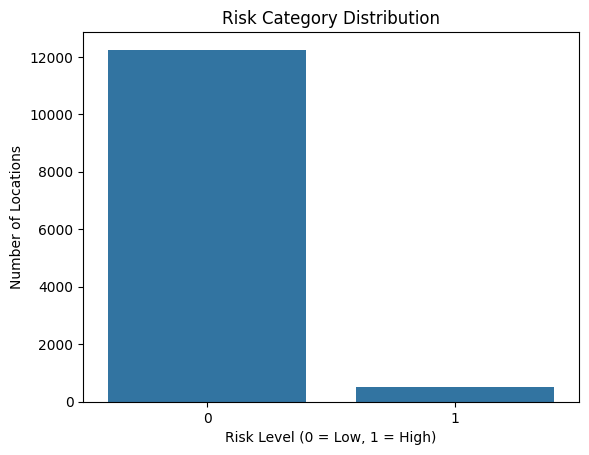

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=features_df, x='risk_category')
plt.title("Risk Category Distribution")
plt.xlabel("Risk Level (0 = Low, 1 = High)")
plt.ylabel("Number of Locations")
plt.show()


**The bar chart shows the distribution of crash risk categories after preprocessing:**

Low risk (1–2 crashes): The vast majority of locations.

High risk (3+ crashes): A relatively small minority of locations.

This highlights a class imbalance problem, where high-risk sites are under-represented.

**Implications for modeling:**

Standard classifiers may become biased toward predicting the majority (low risk).

Performance should be evaluated using macro-averaged metrics (e.g., macro-F1) to ensure minority classes are not ignored.

Techniques such as class weighting, oversampling (SMOTE), or undersampling may be considered to balance training data.

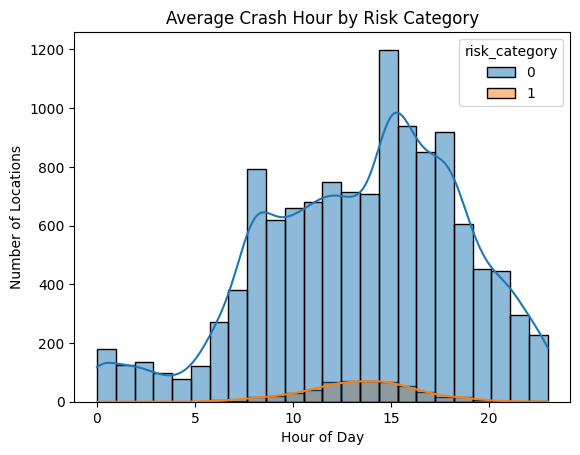

In [18]:
sns.histplot(data=features_df, x='ACCIDENT_HOUR', hue='risk_category', kde=True, bins=24)
plt.title("Average Crash Hour by Risk Category")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Locations")
plt.show()


The histogram with density overlays shows the average crash hour distribution across risk categories:

**Low-risk locations (blue, majority class):**

Crashes are concentrated during daylight and peak traffic hours (8–18h).

A secondary evening peak is visible around 15–18h, coinciding with afternoon commuting.

**High-risk locations (orange, minority class):**

Follow a similar daily pattern, but appear more spread throughout the day.

Some high-risk sites also register in late evening/night hours, suggesting lighting or traffic environment may play a role.

**Implications for modeling:**

Crash risk is strongly time-dependent, and hour-of-day is a meaningful feature.

High-risk sites may be linked to extended activity windows (e.g., nightlife, busy intersections), which supports keeping ACCIDENT_HOUR in the feature set.

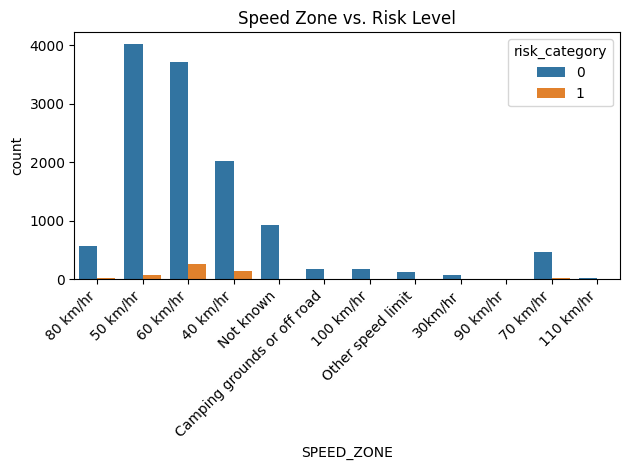

In [19]:
sns.countplot(data=features_df, x='SPEED_ZONE', hue='risk_category')
plt.title("Speed Zone vs. Risk Level")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The bar chart shows the distribution of risk categories across different posted speed zones (0 = Low risk, 1 = High risk):

**50 km/h and 60 km/h zones:**

Contain the largest number of low-risk (0) sites, reflecting how common these zones are in Melbourne’s road network.

However, they also include some high-risk (1) locations, especially in dense pedestrian activity areas.

**40 km/h zones:**

Show a higher proportion of high-risk (1) sites compared to their total count.

These areas are often school zones or shopping precincts with high pedestrian exposure, explaining elevated risk despite lower speed limits.

**High-speed zones (≥80 km/h):**

Appear infrequently overall, but when present, are mostly low-risk (0) sites.

This is likely due to low pedestrian volumes in such environments, though the severity of crashes is typically higher in reality.

**“Not known” zones:**

Contain both low- and high-risk sites, which may indicate data quality gaps or unclassified speed environments.

**Implications for modeling:**

Speed environment is a key feature for predicting crash risk.

The presence of high-risk (1) sites in both 40 km/h and 50–60 km/h zones highlights that exposure and land use (not just speed limits) strongly influence pedestrian safety.

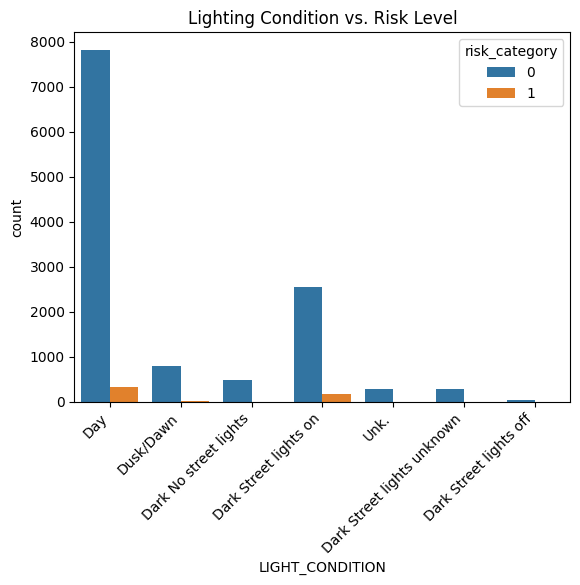

In [20]:
sns.countplot(data=features_df, x='LIGHT_CONDITION', hue='risk_category')
plt.title("Lighting Condition vs. Risk Level")
plt.xticks(rotation=45, ha='right')
plt.show()


The chart compares lighting conditions with crash risk categories (0 = Low risk, 1 = High risk):

**Daytime:**

Most locations fall into low risk (0), but there is still a noticeable share of high-risk (1) sites.

This shows that high pedestrian volumes during the day can still drive risk, even with good visibility.

**Dusk/Dawn:**

Nearly all sites are low risk (0).

Indicates that while crashes do happen at these times, they rarely accumulate into high-risk (1) sites.

**Dark, street lights on:**

Large number of low-risk (0) locations, but also a presence of high-risk (1) sites.

Suggests street lighting helps reduce—but does not fully prevent—pedestrian risk.

**Dark, no street lights:**

Almost entirely low risk (0).

These conditions are rare in the dataset and do not appear strongly linked to high-risk sites.

**Implications for modeling:**

Daytime dominates both low- and high-risk sites, highlighting that exposure (volume of pedestrians and vehicles) matters more than just lighting.

Lighting condition remains a useful feature, but it’s not the sole driver of high-risk (1) sites.

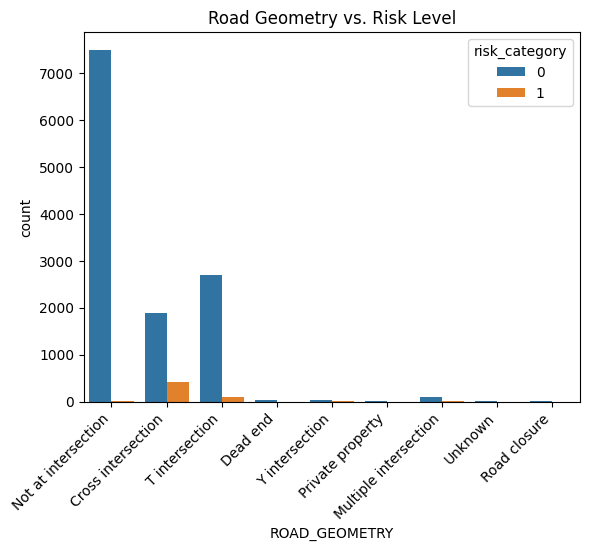

In [21]:
sns.countplot(data=features_df, x='ROAD_GEOMETRY', hue='risk_category')
plt.title("Road Geometry vs. Risk Level")
plt.xticks(rotation=45, ha='right')
plt.show()


The chart compares road geometry types with crash risk categories (0 = Low risk, 1 = High risk):

**Not at intersection:**

By far the largest category, mostly low risk (0).

Reflects the prevalence of mid-block road segments, where crashes are common but rarely accumulate into high-risk clusters.

**Cross intersections:**

Contain a noticeable share of high-risk (1) sites compared to other geometries.

These locations concentrate pedestrian and vehicle flows from multiple directions, increasing conflict points.

**T-intersections:**

Also include several high-risk (1) locations, though fewer than cross intersections.

Still represent significant pedestrian risk due to turning vehicle movements.

**Other geometries (dead ends, Y-intersections, private property, multiple intersections):**

Very small counts overall, with almost all classified as low risk (0).

These road types are less frequent and contribute little to the model.

**Unknown / road closures:**

Rare categories, almost entirely low risk (0).

**Implications for modeling:**

Intersection-related variables (is_intersection, ROAD_GEOMETRY_*) are important features for predicting pedestrian crash risk.

Cross and T-intersections are especially relevant in distinguishing high-risk (1) locations.

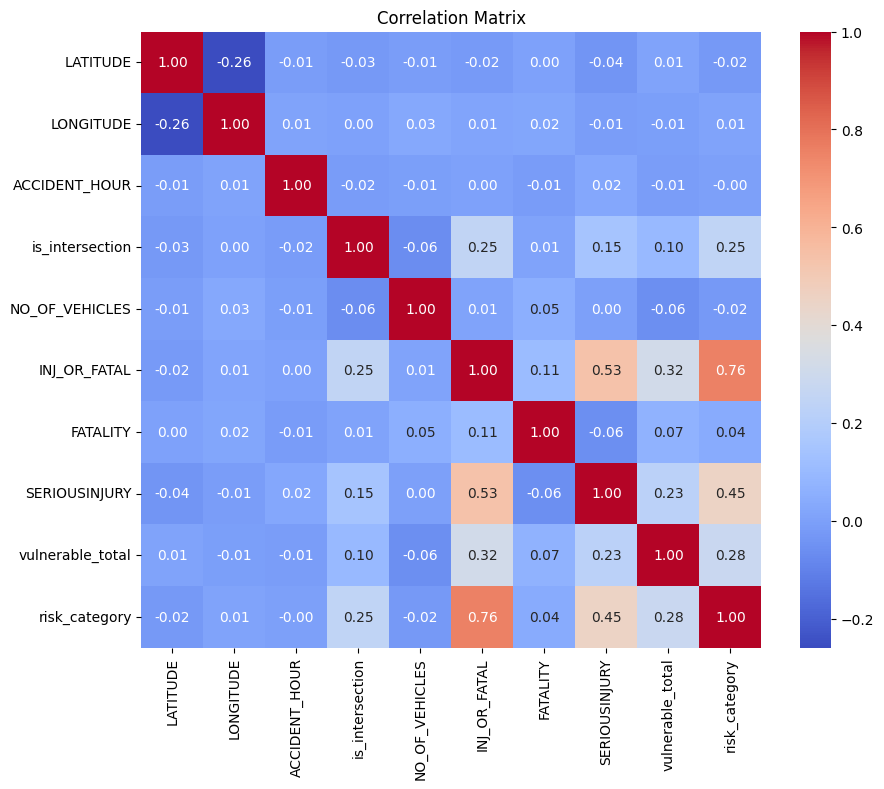

In [22]:
corr = features_df.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


The correlation heatmap highlights linear relationships between engineered features and the target (risk_category, where 0 = low risk, 1 = high risk):

**Strongest correlation with risk_category:**

INJ_OR_FATAL (0.76) — unsurprising, since severe crash outcomes accumulate at high-risk sites.

SERIOUSINJURY (0.45) — also aligned with higher crash severity.

is_intersection (0.25) — confirms intersections are associated with greater pedestrian risk.

vulnerable_total (0.28) — crashes involving children/seniors align with elevated risk.

**Weak correlations:**

ACCIDENT_HOUR and NO_OF_VEHICLES show very low correlation, suggesting limited direct effect on aggregate risk labels.

Geographic coordinates (LATITUDE, LONGITUDE) show no meaningful correlation, which is expected since they are retained only for spatial mapping.

**Feature redundancy:**

INJ_OR_FATAL, SERIOUSINJURY, and FATALITY are strongly correlated with each other.

This suggests potential multicollinearity, and outcome-related features may need exclusion to avoid data leakage.

**Implications for modeling:**

Confirms that intersection type, vulnerable users, and severity-linked features are most predictive of high-risk sites.

Reinforces the need to exclude post-crash outcome variables (INJ_OR_FATAL, SERIOUSINJURY, FATALITY) if the model is intended for pre-crash prediction.

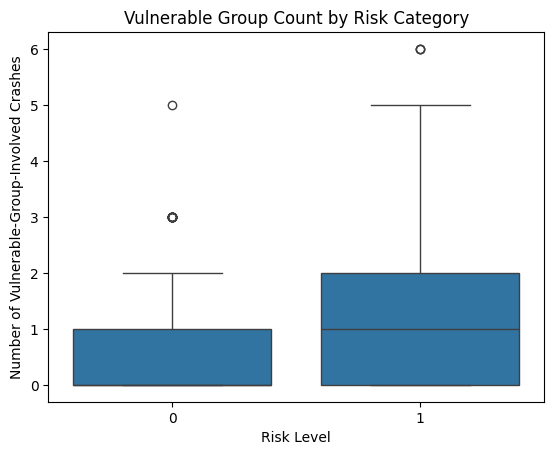

In [23]:
sns.boxplot(data=features_df, x='risk_category', y='vulnerable_total')
plt.title("Vulnerable Group Count by Risk Category")
plt.xlabel("Risk Level")
plt.ylabel("Number of Vulnerable-Group-Involved Crashes")
plt.show()


The boxplot compares the number of vulnerable group–involved crashes (children and seniors) between risk levels (0 = Low risk, 1 = High risk):

**Low-risk sites (0):**

Most locations record 0–1 vulnerable group crashes.

Outliers exist with up to 5 vulnerable-involved crashes, but these are rare.

**High-risk sites (1):**

Tend to have a higher median and wider spread of vulnerable group crashes.

Outliers reach up to 6 vulnerable-involved crashes, indicating clusters where vulnerable users are disproportionately affected.

**Implications for modeling:**

The feature vulnerable_total provides a clear signal differentiating high-risk from low-risk sites.

Confirms domain knowledge: sites where children and older pedestrians are frequently involved are more likely to be classified as high risk.

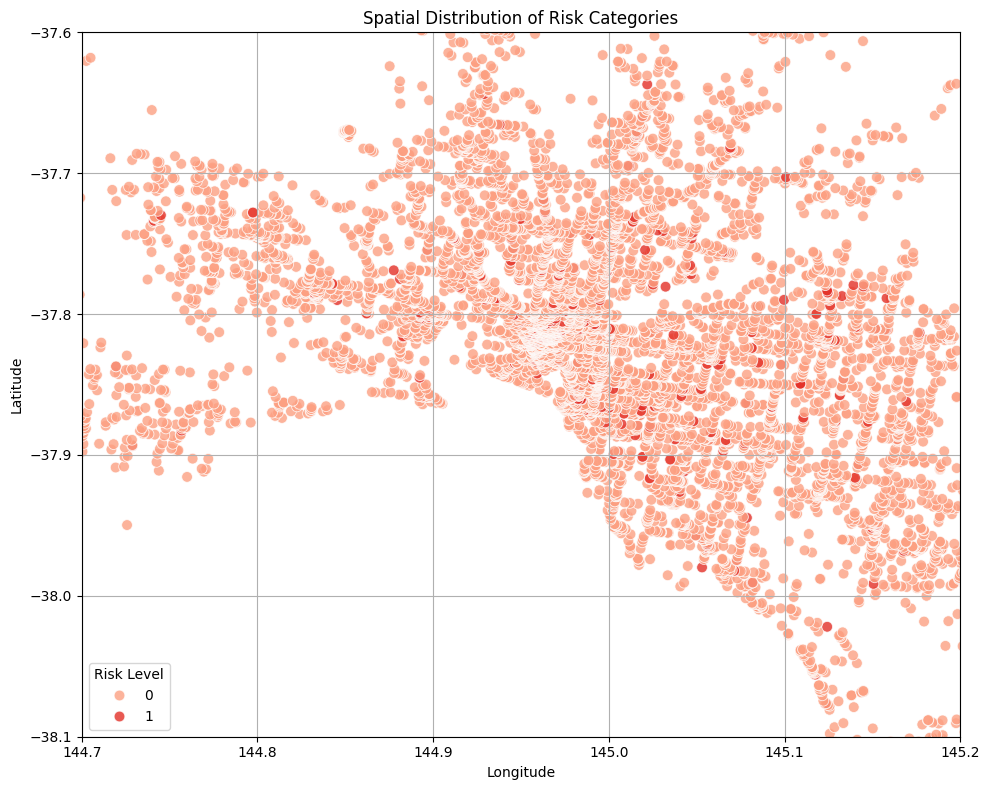

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot size
plt.figure(figsize=(10, 8))

# Create scatter plot with categorical hue
sns.scatterplot(
    data=features_df,
    x='LONGITUDE',
    y='LATITUDE',
    hue='risk_category',
    palette='Reds',   # You can also try 'Set1', 'Dark2', or custom color map
    alpha=0.8,        # Transparency
    s=60              # Marker size
)

# Titles and labels
plt.title("Spatial Distribution of Risk Categories")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Risk Level")

# Optional: zoom into Melbourne area
plt.xlim(144.7, 145.2)
plt.ylim(-38.1, -37.6)

# Layout adjustment
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


The map shows the geographic distribution of pedestrian crash risk categories across Melbourne (0 = Low risk, 1 = High risk):

**Low-risk sites (0):**

Spread across the entire metropolitan area, especially along suburban corridors.

Reflect the general prevalence of locations with only 1–2 pedestrian crashes.

**High-risk sites (1):**

Cluster more visibly in the inner metropolitan area and city centre, where pedestrian activity is dense.

These clusters correspond to areas with higher exposure, such as CBD crossings, major intersections, and transport hubs.

**Implications for modeling and planning:**

Confirms that pedestrian risk is spatially concentrated, not uniformly distributed.

Highlights the value of incorporating urban context features (e.g., intersection type, urban classification) into the model.

Reinforces the potential for model outputs to be visualised as risk heatmaps for planners.

In [25]:
# Convert all boolean columns to 0/1
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)
y = features_df['risk_category']



###  STEP 7: Feature selection
Purpose: Ensure that only pre-crash features are used for prediction, so the model can generalise to unseen locations and not rely on outcome data that would only be known after a crash.

Logic:

- Drop variables that directly describe post-crash severity or outcomes.

- Drop unknown feature.

- Retain features related to road environment, geometry, lighting, and speed, which are observable prior to crashes.

In [26]:
import pandas as pd

# Combine X and y to compute correlation
combined_df = pd.concat([X, y], axis=1)

# Pearson correlation with target
pearson_corr = combined_df.corr(method='pearson')['risk_category'].sort_values(ascending=False)

# Spearman correlation with target
spearman_corr = combined_df.corr(method='spearman')['risk_category'].sort_values(ascending=False)

print("\n=== Pearson correlation with risk_category ===")
print(pearson_corr)

print("\n=== Spearman correlation with risk_category ===")
print(spearman_corr)



=== Pearson correlation with risk_category ===
risk_category                                 1.000000
INJ_OR_FATAL                                  0.756693
SERIOUSINJURY                                 0.453961
vulnerable_total                              0.277456
is_intersection                               0.245484
DTP_REGION_INNER METRO                        0.100540
SPEED_ZONE_60 km/hr                           0.078697
DEG_URBAN_NAME_MELBOURNE_CBD                  0.073415
LIGHT_CONDITION_Dark Street lights on         0.061688
SPEED_ZONE_40 km/hr                           0.060990
DEG_URBAN_NAME_MELB_URBAN                     0.048506
ROAD_GEOMETRY_Multiple intersection           0.047199
FATALITY                                      0.039316
DAY_OF_WEEK_Monday                            0.028414
LONGITUDE                                     0.010368
SPEED_ZONE_70 km/hr                           0.009772
LIGHT_CONDITION_Dark Street lights off        0.007628
ROAD_GEOMETRY_Y i

In [27]:
X = X.drop(["LATITUDE", "LONGITUDE", "INJ_OR_FATAL", "SERIOUSINJURY", "FATALITY", "SPEED_ZONE_Not known","ROAD_GEOMETRY_Unknown","ROAD_GEOMETRY_Dead end", "ROAD_GEOMETRY_Private property","ROAD_GEOMETRY_Road closure","SPEED_ZONE_Other speed limit","vulnerable_total"], axis=1)

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12760 entries, 0 to 12865
Data columns (total 40 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   ACCIDENT_HOUR                               12760 non-null  float64
 1   is_intersection                             12760 non-null  int64  
 2   NO_OF_VEHICLES                              12760 non-null  float64
 3   DAY_OF_WEEK_Monday                          12760 non-null  int64  
 4   DAY_OF_WEEK_Saturday                        12760 non-null  int64  
 5   DAY_OF_WEEK_Sunday                          12760 non-null  int64  
 6   DAY_OF_WEEK_Thursday                        12760 non-null  int64  
 7   DAY_OF_WEEK_Tuesday                         12760 non-null  int64  
 8   DAY_OF_WEEK_Wednesday                       12760 non-null  int64  
 9   SPEED_ZONE_110 km/hr                        12760 non-null  int64  
 10  SPEED_ZONE_30km

In [29]:
X.describe()

,ACCIDENT_HOUR,is_intersection,NO_OF_VEHICLES,DAY_OF_WEEK_Monday,DAY_OF_WEEK_Saturday,DAY_OF_WEEK_Sunday,DAY_OF_WEEK_Thursday,DAY_OF_WEEK_Tuesday,DAY_OF_WEEK_Wednesday,SPEED_ZONE_110 km/hr,...,DEG_URBAN_NAME_RURAL_VICTORIA,DEG_URBAN_NAME_SMALL_CITIES,DEG_URBAN_NAME_SMALL_TOWNS,DEG_URBAN_NAME_TOWNS,DTP_REGION_GIPPSLAND,DTP_REGION_GRAMPIANS,DTP_REGION_GREATER METRO,DTP_REGION_HUME,DTP_REGION_INNER METRO,DTP_REGION_LODDON MALLEE
count,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,...,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000
mean,13.521885,0.407367,1.048177,0.140517,0.129859,0.095219,0.157680,0.143103,0.149687,0.001411,...,0.030251,0.070455,0.007210,0.050940,0.034091,0.029545,0.262382,0.031191,0.543495,0.041614
std,5.039217,0.491363,0.238575,0.347536,0.336161,0.293529,0.364455,0.350192,0.356778,0.037534,...,0.171283,0.255922,0.084609,0.219885,0.181470,0.169336,0.439947,0.173841,0.498124,0.199714
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,17.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,23.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### STEP 8: Train/Test Split (for upcoming modeling)

In [30]:
from sklearn.preprocessing import StandardScaler

# Suppose you already have X_encoded and y
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)  # returns a NumPy array
X_scaled

array([[ 0.49178514, -0.82908642, -0.20194323, ..., -0.17943087,
        -1.09112691, -0.20837796],
       [-1.09582516,  1.20614688, -0.20194323, ..., -0.17943087,
        -1.09112691, -0.20837796],
       [-0.10356872, -0.82908642, -0.20194323, ..., -0.17943087,
        -1.09112691, -0.20837796],
       ...,
       [ 0.88868771, -0.82908642, -0.20194323, ..., -0.17943087,
        -1.09112691,  4.79897196],
       [ 0.69023643, -0.82908642, -0.20194323, ..., -0.17943087,
        -1.09112691,  4.79897196],
       [-1.69117903, -0.82908642, -0.20194323, ..., -0.17943087,
        -1.09112691,  4.79897196]])

In [31]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)   # now classes start at 0


In [32]:

from sklearn.model_selection import train_test_split

# Assuming X_encoded and y are defined
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,       # 20% test, 80% train
    random_state=42,     # For reproducibility
    stratify=y
)


In [33]:
import pandas as pd

pd.Series(y_train).value_counts()


,count
0,9797
1,411


### STEP 10: Oversampling

In [34]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [35]:
pd.Series(y_train).value_counts()

,count
0,9797
1,9797


## Machine learning


### Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, learning_curve, validation_curve
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score,
    roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [50]:
# --- Define base Logistic Regression model ---
log_reg = LogisticRegression(
    solver="saga",       # supports l1/l2/elasticnet for multinomial
    multi_class="multinomial",
    max_iter=5000,
    random_state=42,
    n_jobs=-1
)

In [51]:
# --- Parameter grid ---
param_grid = {
    "C": [0.01, 0.1, 1, 10],       # regularization strength (inverse of lambda)
    "penalty": ["l2"],             # using l2 (ridge)
    "class_weight": [None, "balanced"]
}

In [52]:
cv = 5

## --- GridSearchCV with macro F1 ---
grid_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True   # <— add this
)
grid_lr.fit(X_train, y_train)

cv_results_lr = pd.DataFrame(grid_lr.cv_results_).sort_values("mean_test_score", ascending=False)
display(cv_results_lr[[
    "mean_test_score","std_test_score","mean_train_score","std_train_score","params"
]].head(10))


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


,mean_test_score,std_test_score,mean_train_score,std_train_score,params
3,0.886461,0.007361,0.886816,0.001885,"{'C': 0.1, 'class_weight': 'balanced', 'penalt..."
2,0.886461,0.007361,0.886803,0.001863,"{'C': 0.1, 'class_weight': None, 'penalty': 'l2'}"
6,0.886424,0.007407,0.887050,0.001606,"{'C': 10, 'class_weight': None, 'penalty': 'l2'}"
7,0.886424,0.007407,0.887050,0.001606,"{'C': 10, 'class_weight': 'balanced', 'penalty..."
5,0.886267,0.007641,0.886995,0.001591,"{'C': 1, 'class_weight': 'balanced', 'penalty'..."
4,0.886267,0.007641,0.886995,0.001591,"{'C': 1, 'class_weight': None, 'penalty': 'l2'}"
1,0.885066,0.008050,0.885818,0.002702,"{'C': 0.01, 'class_weight': 'balanced', 'penal..."
0,0.885014,0.008022,0.885818,0.002702,"{'C': 0.01, 'class_weight': None, 'penalty': '..."


In [53]:
# --- Show top results from grid search ---
cv_results_lr = pd.DataFrame(grid_lr.cv_results_)
cv_results_lr = cv_results_lr.sort_values("mean_test_score", ascending=False)
display(cv_results_lr[["mean_test_score", "std_test_score", "mean_train_score", "std_train_score", "params"]].head(10))


,mean_test_score,std_test_score,mean_train_score,std_train_score,params
3,0.886461,0.007361,0.886816,0.001885,"{'C': 0.1, 'class_weight': 'balanced', 'penalt..."
2,0.886461,0.007361,0.886803,0.001863,"{'C': 0.1, 'class_weight': None, 'penalty': 'l2'}"
6,0.886424,0.007407,0.887050,0.001606,"{'C': 10, 'class_weight': None, 'penalty': 'l2'}"
7,0.886424,0.007407,0.887050,0.001606,"{'C': 10, 'class_weight': 'balanced', 'penalty..."
5,0.886267,0.007641,0.886995,0.001591,"{'C': 1, 'class_weight': 'balanced', 'penalty'..."
4,0.886267,0.007641,0.886995,0.001591,"{'C': 1, 'class_weight': None, 'penalty': 'l2'}"
1,0.885066,0.008050,0.885818,0.002702,"{'C': 0.01, 'class_weight': 'balanced', 'penal..."
0,0.885014,0.008022,0.885818,0.002702,"{'C': 0.01, 'class_weight': None, 'penalty': '..."


In [54]:
# --- Test set evaluation ---
best_lr = grid_lr.best_estimator_

# --- Test set evaluation ---
y_pred_lr = best_lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred_lr, labels=[0,1])
cm_norm = confusion_matrix(y_test, y_pred_lr, labels=[0,1], normalize="true")

print("\nClassification Report (LogReg on Test Set):")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_.astype(str), digits=3))

macro_f1_test_lr = f1_score(y_test, y_pred_lr, average="macro")
print("Test Macro F1:", round(macro_f1_test_lr, 4))



Classification Report (LogReg on Test Set):
              precision    recall  f1-score   support

           0      0.992     0.842     0.911      2449
           1      0.183     0.845     0.301       103

    accuracy                          0.842      2552
   macro avg      0.588     0.843     0.606      2552
weighted avg      0.960     0.842     0.886      2552

Test Macro F1: 0.6059


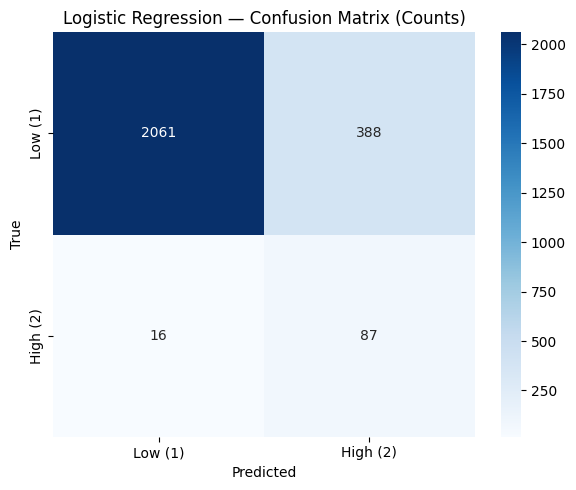

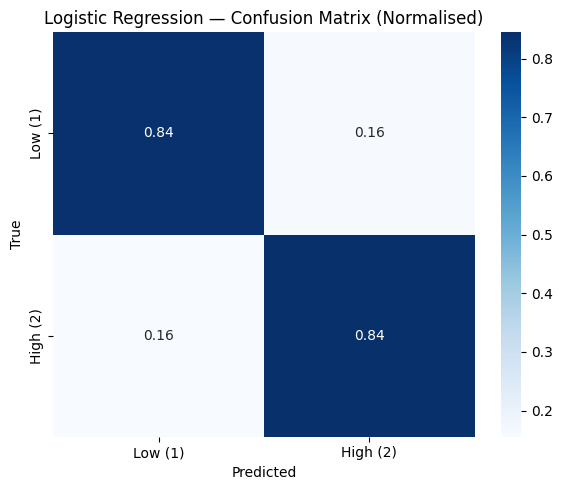

In [55]:
# Confusion matrix (counts)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low (1)", "High (2)"],
            yticklabels=["Low (1)", "High (2)"])
plt.title("Logistic Regression — Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Confusion matrix (normalised)
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Low (1)","High (2)"],
            yticklabels=["Low (1)", "High (2)"])
plt.title("Logistic Regression — Confusion Matrix (Normalised)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [56]:
# --- Cross-validation on full dataset ---
cv_scores_lr = cross_val_score(best_lr, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
print("CV Macro F1 scores:", np.round(cv_scores_lr, 4))
print("CV Macro F1 mean:", round(cv_scores_lr.mean(), 4), " | std:", round(cv_scores_lr.std(), 4))


CV Macro F1 scores: [0.4898 0.4897 0.4897 0.4897 0.4897]
CV Macro F1 mean: 0.4897  | std: 0.0


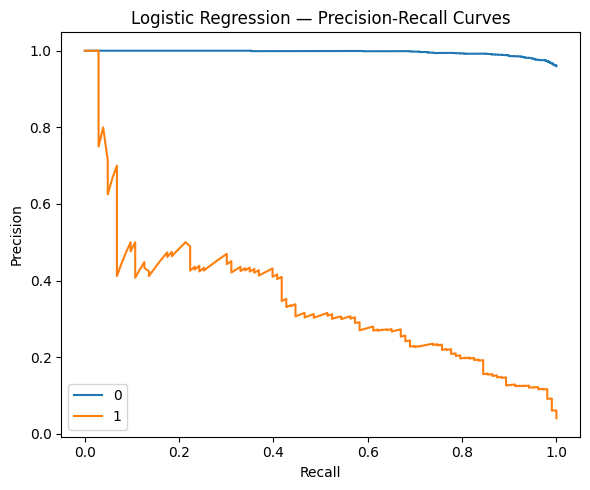

In [57]:
#Precision-Recall curves (OvR) ---
if hasattr(best_lr, "predict_proba"):
    y_test_bin = label_binarize(y_test, classes=[0,1,2])
    y_prob = best_lr.predict_proba(X_test)

# Precision-Recall
    plt.figure(figsize=(6,5))
    for i, cname in enumerate(le.classes_):
        prec, rec, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
        plt.plot(rec, prec, label=cname)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Logistic Regression — Precision-Recall Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [58]:
# --- Final Results Summary for Logistic Regression ---

from sklearn.metrics import precision_score, recall_score

# Compute extra metrics on the test set
test_acc_lr = best_lr.score(X_test, y_test)
test_prec_lr = precision_score(y_test, y_pred_lr, average="macro", zero_division=0)
test_rec_lr  = recall_score(y_test, y_pred_lr, average="macro", zero_division=0)
test_f1_lr   = f1_score(y_test, y_pred_lr, average="macro")

results_lr = pd.DataFrame([{
    "Model": "Logistic Regression",
    "Best Params": grid_lr.best_params_,
    "Test Accuracy": round(test_acc_lr, 4),
    "Test Precision (macro)": round(test_prec_lr, 4),
    "Test Recall (macro)": round(test_rec_lr, 4),
    "Test F1 (macro)": round(test_f1_lr, 4),
    "CV F1 (macro mean)": round(cv_scores_lr.mean(), 4),
    "CV F1 (macro std)": round(cv_scores_lr.std(), 4)
}])

display(results_lr)


,Model,Best Params,Test Accuracy,Test Precision (macro),Test Recall (macro),Test F1 (macro),CV F1 (macro mean),CV F1 (macro std)
0,Logistic Regression,"{'C': 0.1, 'class_weight': None, 'penalty': 'l2'}",0.8417,0.5877,0.8431,0.6059,0.4897,0.0


### Random Forest

Hyperparameter Tuning (GridSearchCV with macro F1)

In [59]:
# --- Hyperparameter Tuning for Random Forest ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Base model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    "n_estimators": [200, 300, 500],      # number of trees
    "max_depth": [10, 20, None],          # tree depth (None = full growth)
    "min_samples_split": [2, 5,10],          # split regularization
    "min_samples_leaf": [1, 2,4],           # leaf size regularization
    "class_weight": [None, "balanced"]    # imbalance handling; "balanced" weights by class frequencies
}

# Use macro F1 to give each class equal importance
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                      # 5-fold CV inside the grid search
    scoring="f1_macro",        # optimize for macro F1
    n_jobs=-1,                 # use all available cores
    verbose=1
)

grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Best Params:", grid.best_params_)


Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Params: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


Test Set Evaluation (Confusion Matrix, Precision, Recall, Macro F1)


In [60]:
# --- Evaluate best model on the test set ---

from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np

# Predict on test split
y_pred = best_rf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])  # enforce class order: 1=Low, 2=Med, 3=High
print("Confusion Matrix (rows=true, cols=pred):\n", cm)

# Full classification report (per-class precision/recall/F1 + macro/weighted)
report_text = classification_report(y_test, y_pred, digits=3)
print(report_text)

# Macro F1 (explicit)
macro_f1_test = f1_score(y_test, y_pred, average="macro")
print("Test Macro F1:", round(macro_f1_test, 4))


Confusion Matrix (rows=true, cols=pred):
 [[2406   43]
 [  54   49]]
              precision    recall  f1-score   support

           0      0.978     0.982     0.980      2449
           1      0.533     0.476     0.503       103

    accuracy                          0.962      2552
   macro avg      0.755     0.729     0.741      2552
weighted avg      0.960     0.962     0.961      2552

Test Macro F1: 0.7414


Confusion Matrix Heatmap

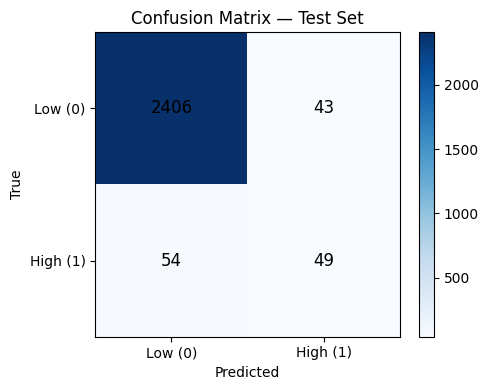

In [61]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap='Blues')  # Add color using cmap

plt.title("Confusion Matrix — Test Set")
plt.xticks([0, 1], ["Low (0)", "High (1)"])
plt.yticks([0, 1], ["Low (0)", "High (1)"])

# Add annotations for each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=12)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()  # Show color scale
plt.tight_layout()
plt.show()


Cross‑Validation on Full Data (Generalization Check)

In [62]:
# --- Cross‑validation estimate using the tuned model ---

from sklearn.model_selection import cross_val_score, StratifiedKFold

# Use a stratified split to maintain class ratios across folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_rf_for_cv = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    **{k: v for k, v in grid.best_params_.items() if k in rf.get_params()}  # inject best params safely
)

cv_scores = cross_val_score(
    best_rf_for_cv, X_train, y_train,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

print("CV Macro F1 scores:", np.round(cv_scores, 4))
print("CV Macro F1 mean:", round(cv_scores.mean(), 4), " | std:", round(cv_scores.std(), 4))


CV Macro F1 scores: [0.9758 0.9719 0.9724 0.9699 0.974 ]
CV Macro F1 mean: 0.9728  | std: 0.002


Summary Table

In [63]:
# --- Results summary dataframe ---

import pandas as pd

results_summary = pd.DataFrame([{
    "Model": "RandomForest",
    "Best Params": grid.best_params_,
    "Test Macro F1": round(macro_f1_test, 4),
    "CV Macro F1 (mean)": round(cv_scores.mean(), 4),
    "CV Macro F1 (std)": round(cv_scores.std(), 4)
}])

results_summary


,Model,Best Params,Test Macro F1,CV Macro F1 (mean),CV Macro F1 (std)
0,RandomForest,"{'class_weight': None, 'max_depth': None, 'min...",0.7414,0.9728,0.002


Feature Importance (Top Predictors)

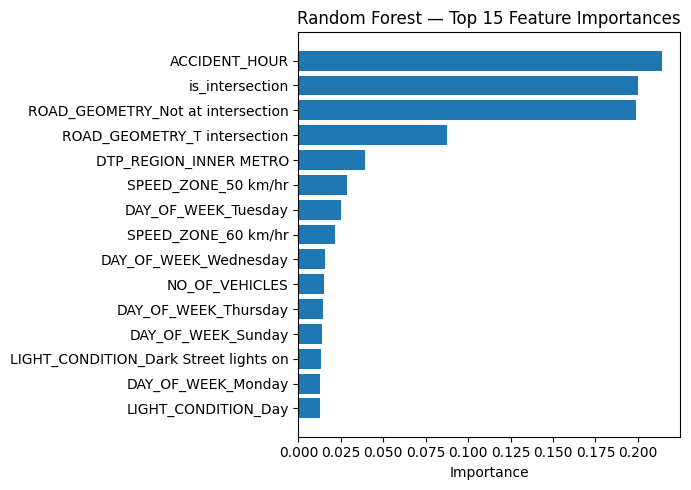

In [64]:
# --- Top Feature Importances Plot ---

import numpy as np
import matplotlib.pyplot as plt

# Get importances and feature names
importances = best_rf.feature_importances_
feat_names = np.array(X.columns)

# Cap k to available features
top_k_requested = 15
k = int(min(top_k_requested, importances.size))

#Pick top-k indices (descending importance)
order_desc = np.argsort(importances)[::-1][:k]

vals = importances[order_desc][::-1]
labels = feat_names[order_desc][::-1]

#Plot
plt.figure(figsize=(7, 5))
plt.barh(np.arange(k), vals)
plt.yticks(np.arange(k), labels)
plt.xlabel("Importance")
plt.title(f"Random Forest — Top {k} Feature Importances")
plt.tight_layout()
plt.show()


### SVM


=== Evaluation for SVM (RBF Kernel) ===
------------------------------------------------------------
CV Macro-F1: 0.9491 ± 0.0003

Classification Report (Test Set):
              precision    recall  f1-score   support

           0      0.986     0.920     0.952      2449
           1      0.263     0.680     0.379       103

    accuracy                          0.910      2552
   macro avg      0.624     0.800     0.666      2552
weighted avg      0.956     0.910     0.929      2552

Test Macro-F1: 0.6655


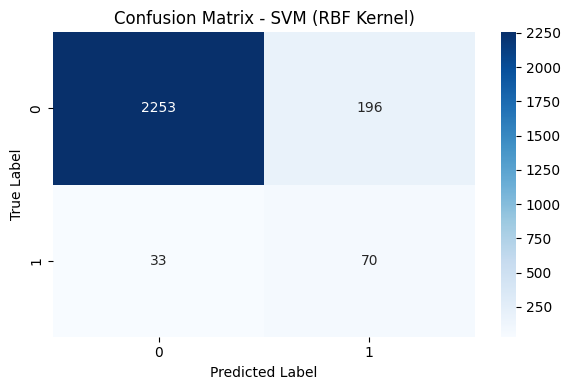


=== Evaluation for LinearSVC (Fast Linear Kernel) ===
------------------------------------------------------------
Skipping CV for LinearSVC (fast enough, trained once).

Classification Report (Test Set):
              precision    recall  f1-score   support

           0      0.992     0.838     0.909      2449
           1      0.180     0.845     0.297       103

    accuracy                          0.839      2552
   macro avg      0.586     0.841     0.603      2552
weighted avg      0.959     0.839     0.884      2552

Test Macro-F1: 0.6029


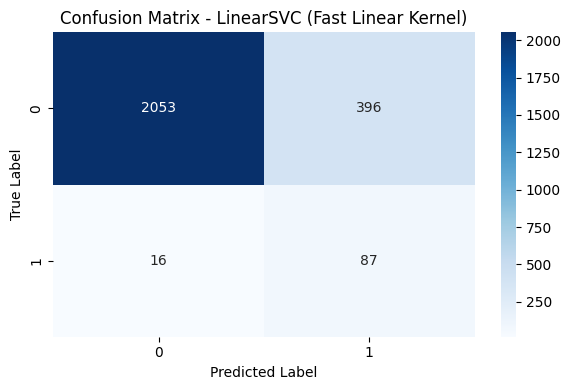

In [36]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# Evaluation function
# --------------------------
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    print(f"\n=== Evaluation for {model_name} ===")
    print("-" * 60)

    # --------------------------
    # Cross-validation on training set
    # --------------------------
    if not isinstance(model, LinearSVC):
        # SVC may take long for large data; optionally skip CV for very slow models
        cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1_macro", n_jobs=-1)
        print("CV Macro-F1: %.4f ± %.4f" % (cv_scores.mean(), cv_scores.std()))
    else:
        print("Skipping CV for LinearSVC (fast enough, trained once).")

    # --------------------------
    # Train on full training set
    # --------------------------
    model.fit(X_train, y_train)

    # --------------------------
    # Test set evaluation
    # --------------------------
    y_pred = model.predict(X_test)
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred, digits=3))

    test_f1 = f1_score(y_test, y_pred, average="macro")
    print("Test Macro-F1: %.4f" % test_f1)

    # --------------------------
    # Confusion matrix
    # --------------------------
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# --------------------------
# Models
# --------------------------
svm_rbf = SVC(kernel='rbf', random_state=42, gamma='scale', C=10,
              class_weight='balanced', decision_function_shape='ovo')

svm_linear_fast = LinearSVC(C=100, class_weight='balanced',
                            random_state=42, max_iter=5000)

# --------------------------
# Evaluate models
# --------------------------
evaluate_model(svm_rbf, X_train, y_train, X_test, y_test, "SVM (RBF Kernel)")
evaluate_model(svm_linear_fast, X_train, y_train, X_test, y_test, "LinearSVC (Fast Linear Kernel)")


### XG BOOST

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Classification Report:
              precision    recall  f1-score   support

           0     0.9909    0.9771    0.9840      2449
           1     0.5912    0.7864    0.6750       103

    accuracy                         0.9694      2552
   macro avg     0.7911    0.8818    0.8295      2552
weighted avg     0.9748    0.9694    0.9715      2552



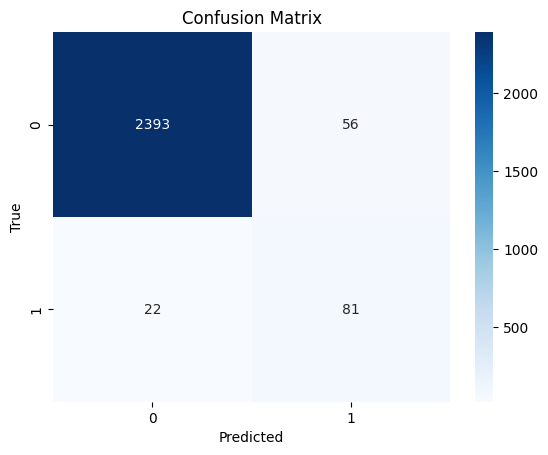


Macro-F1 Score: 0.8294819078947369

CV Macro-F1: 0.9767 ± 0.0095
Test set Macro-F1: 0.8295

Top 10 feature importances:


,importance
is_intersection,0.811701
ROAD_GEOMETRY_Not at intersection,0.104143
ROAD_GEOMETRY_T intersection,0.016669
NO_OF_VEHICLES,0.006017
DAY_OF_WEEK_Sunday,0.005963
LIGHT_CONDITION_Dark Street lights on,0.005691
DTP_REGION_INNER METRO,0.005410
DAY_OF_WEEK_Tuesday,0.004413
ACCIDENT_HOUR,0.004210
DEG_URBAN_NAME_TOWNS,0.003791


In [37]:
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# ---------------------------
# 2. XGBoost hyperparameter tuning
# ---------------------------
param_dist = {
    "n_estimators": [500, 1000, 1500],
    "max_depth": [3, 4, 5],
    "min_child_weight": [3, 5, 7],
    "learning_rate": [0.01, 0.03, 0.05],
    "subsample": [0.6, 0.8,1],
    "colsample_bytree": [0.6, 0.8,1],
    "gamma": [0, 1, 3],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 5, 10]
}

xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# ---------------------------
# 3. Fit model on resampled data
# ---------------------------
random_search.fit(X_train, y_train)
best_xgb = random_search.best_estimator_

# ---------------------------
# 4. Evaluate on test set
# ---------------------------
y_pred = best_xgb.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nMacro-F1 Score:", f1_score(y_test, y_pred, average="macro"))

# ---------------------------
# 5. Cross-validation check
# ---------------------------
cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring="f1_macro")
print("\nCV Macro-F1: %.4f ± %.4f" % (cv_scores.mean(), cv_scores.std()))
print("Test set Macro-F1: %.4f" % f1_score(y_test, y_pred, average="macro"))

# Feature importance (top 10)
try:
    fi = pd.Series(best_xgb .feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
    print("\nTop 10 feature importances:")
    display(fi.to_frame("importance"))
except Exception as e:
    print("Feature importances unavailable:", e)

In [38]:
# Show the best parameter set
print("Best parameters found:")
print(random_search.best_params_)

# Best model
best_xgb = random_search.best_estimator_
print("\nBest XGB model:")
print(best_xgb)


Best parameters found:
{'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 1500, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}

Best XGB model:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1500, n_jobs=-1,
              num_parallel_tree=None, ...)


### Decision Tree

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy'}

Decision Tree — Classification Report
              precision    recall  f1-score   support

           0     0.9862    0.9886    0.9874      2449
           1     0.7113    0.6699    0.6900       103

    accuracy                         0.9757      2552
   macro avg     0.8487    0.8292    0.8387      2552
weighted avg     0.9751    0.9757    0.9754      2552



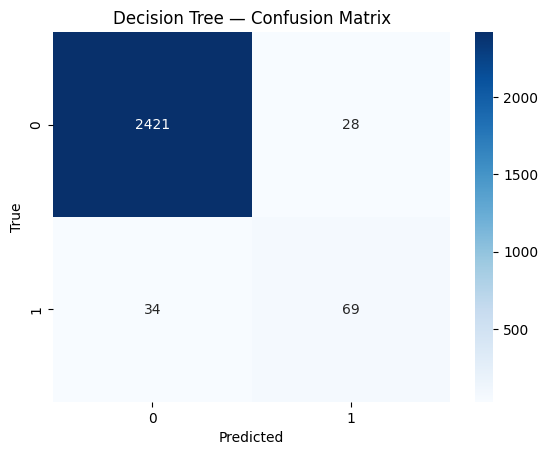

Macro-F1: 0.8386786296900489
CV Macro-F1: 0.9754 ± 0.0009

Top 10 feature importances:


,importance
is_intersection,0.421054
ACCIDENT_HOUR,0.321806
ROAD_GEOMETRY_T intersection,0.124635
LIGHT_CONDITION_Dark Street lights on,0.029693
SPEED_ZONE_50 km/hr,0.017681
NO_OF_VEHICLES,0.011485
DTP_REGION_INNER METRO,0.008807
DEG_URBAN_NAME_MELB_URBAN,0.007563
DAY_OF_WEEK_Saturday,0.005769
DAY_OF_WEEK_Monday,0.004825


In [39]:
# Decision Tree (tuning -> train -> CV -> evaluate)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# handle tiny classes safely
min_per_class = pd.Series(y_train).value_counts().min()
can_cv = min_per_class >= 2
cv_splits = max(2, min(5, int(min_per_class)))  # 2..5

dt = DecisionTreeClassifier(random_state=42)

param_dist_dt = {
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [5, 10, 20],
    "min_samples_leaf": [2, 5, 10],
    "criterion": ["gini", "entropy"]
}

# class-imbalance weights
train_w = compute_sample_weight(class_weight="balanced", y=y_train)

if can_cv:
    dt_search = RandomizedSearchCV(
        dt,
        param_distributions=param_dist_dt,
        n_iter=20,
        scoring="f1_macro",
        cv=StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42),
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    dt_search.fit(X_train, y_train, sample_weight=train_w)  # pass weights into CV fits
    best_dt = dt_search.best_estimator_
    print("Best params:", dt_search.best_params_)
else:
    print("Skipping RandomizedSearchCV")
    best_dt = dt.fit(X_train, y_train, sample_weight=train_w)

# Evaluation
y_pred = best_dt.predict(X_test)
print("\nDecision Tree — Classification Report")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

print("Macro-F1:", f1_score(y_test, y_pred, average="macro"))

# Overfitting check (CV on train vs test)
if can_cv:
    cv_scores = cross_val_score(best_dt, X_train, y_train,
    cv=StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42), scoring="f1_macro", n_jobs=-1)
    print("CV Macro-F1: %.4f ± %.4f" % (cv_scores.mean(), cv_scores.std()))

# Feature importance (top 10)
try:
    fi = pd.Series(best_dt.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)
    print("\nTop 10 feature importances:")
    display(fi.to_frame("importance"))
except Exception as e:
    print("Feature importances unavailable:", e)


### KNN

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'clf__weights': 'distance', 'clf__p': 1, 'clf__n_neighbors': 5}

KNN — Classification Report
              precision    recall  f1-score   support

           0     0.9777    0.9661    0.9719      2449
           1     0.3712    0.4757    0.4170       103

    accuracy                         0.9463      2552
   macro avg     0.6744    0.7209    0.6944      2552
weighted avg     0.9532    0.9463    0.9495      2552



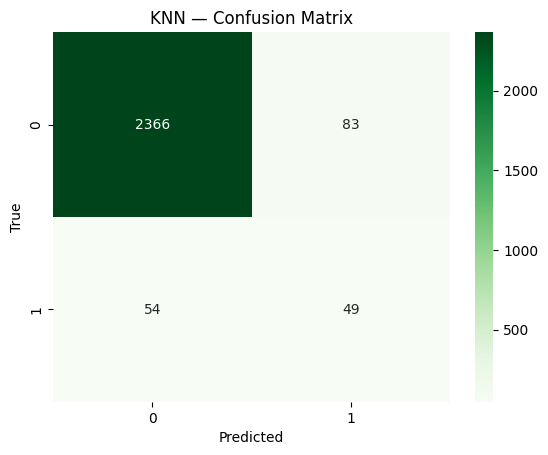

Macro-F1: 0.6944420410499775
CV Macro-F1: 0.9625 ± 0.0022


In [40]:
# KNN (tuning -> train -> CV -> evaluate)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

min_per_class = pd.Series(y_train).value_counts().min()
can_cv = min_per_class >= 2
cv_splits = max(2, min(5, int(min_per_class)))  # 2..5

knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])


param_dist_knn = {
    "clf__n_neighbors": [ 5, 7, 9, 11,13, 15],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]  # 1=Manhattan, 2=Euclidean
}

if can_cv:
    knn_search = RandomizedSearchCV(
        knn_pipe,
        param_distributions=param_dist_knn,
        n_iter=20,
        scoring="f1_macro",
        cv=StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42),
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    knn_search.fit(X_train, y_train)
    best_knn = knn_search.best_estimator_
    print("Best params:", knn_search.best_params_)
else:
    print("Skipping RandomizedSearchCV")
    best_knn = knn_pipe.fit(X_train, y_train)

# Evaluation
y_pred = best_knn.predict(X_test)
print("\nKNN — Classification Report")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("KNN — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

print("Macro-F1:", f1_score(y_test, y_pred, average="macro"))

# Overfitting check (CV on train vs test)
if can_cv:
    cv_scores = cross_val_score(best_knn, X_train, y_train,
                                cv=StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42),
                                scoring="f1_macro", n_jobs=-1)
    print("CV Macro-F1: %.4f ± %.4f" % (cv_scores.mean(), cv_scores.std()))


### Neural network

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'mlp__activation': 'tanh', 'mlp__alpha': np.float64(0.009588855372533333), 'mlp__hidden_layer_sizes': (32, 16), 'mlp__learning_rate': 'adaptive'}
Best CV F1 Score (search): 0.9583678974460271

Classification Report (Test Set):
              precision    recall  f1-score   support

           0      0.987     0.927     0.956      2449
           1      0.288     0.699     0.408       103

    accuracy                          0.918      2552
   macro avg      0.637     0.813     0.682      2552
weighted avg      0.958     0.918     0.934      2552



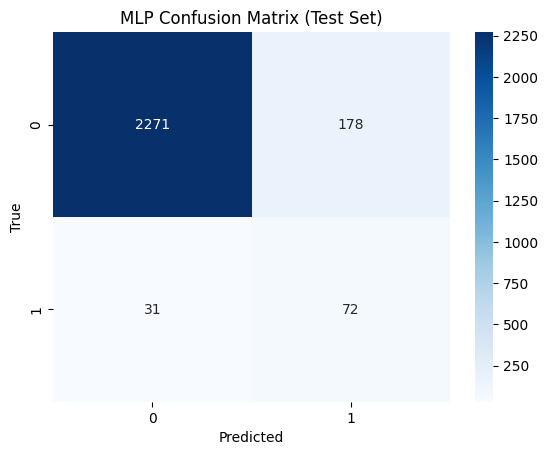


Test Macro-F1: 0.6819706362698057

CV Macro-F1: 0.9571 ± 0.0066
Test set Macro-F1: 0.6820


In [41]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from scipy.stats import uniform
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# 1. Define pipeline + hyperparameter search
# ---------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        random_state=42,
        early_stopping=True,
        max_iter=200
    ))
])

param_dist = {
    'mlp__hidden_layer_sizes': [(16,), (32,), (64,), (32, 16)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': uniform(0.0001, 0.01),
    'mlp__learning_rate': ['constant', 'adaptive']
}

rand_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# ---------------------------
# 2. Fit hyperparameter search
# ---------------------------
rand_search.fit(X_train, y_train)
best_mlp = rand_search.best_estimator_

print("Best Parameters:", rand_search.best_params_)
print("Best CV F1 Score (search):", rand_search.best_score_)

# ---------------------------
# 3. Retrain best model on full training set
# ---------------------------
best_mlp.fit(X_train, y_train)

# ---------------------------
# 4. Evaluate on test set
# ---------------------------
y_pred = best_mlp.predict(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MLP Confusion Matrix (Test Set)")
plt.show()

print("\nTest Macro-F1:", f1_score(y_test, y_pred, average="macro"))

# ---------------------------
# 5. Cross-validation check (overfitting)
# ---------------------------
cv_scores = cross_val_score(best_mlp, X_train, y_train, cv=5, scoring="f1_macro")
print("\nCV Macro-F1: %.4f ± %.4f" % (cv_scores.mean(), cv_scores.std()))
print("Test set Macro-F1: %.4f" % f1_score(y_test, y_pred, average="macro"))


### voting classifier for xgboost and decision tree


Voting ( DT +XGBOOST) — Classification Report
              precision    recall  f1-score   support

           0     0.9898    0.9886    0.9892      2449
           1     0.7358    0.7573    0.7464       103

    accuracy                         0.9792      2552
   macro avg     0.8628    0.8729    0.8678      2552
weighted avg     0.9795    0.9792    0.9794      2552

Macro-F1 (test): 0.867792054190635


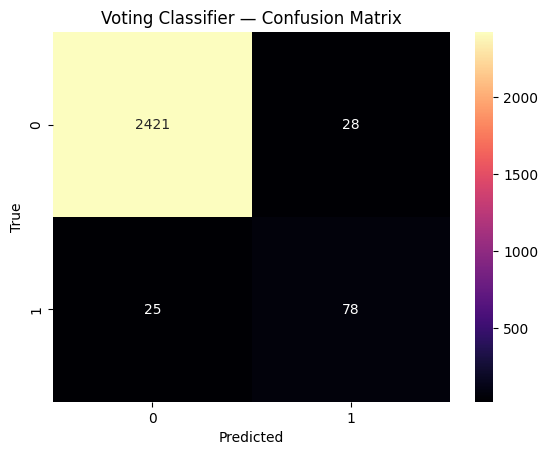

CV Macro-F1 (Voting): 0.9798 ± 0.0025


In [42]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns, matplotlib.pyplot as plt

# --- 1) Build the two estimators ---
# Reuse your tuned models if you have them as best_dt
# Otherwise, define reasonable defaults here:

dt_est = best_dt

xgb_est = best_xgb

# # --- 2) VotingClassifier (soft voting uses predict_proba from both models) ---
voter = VotingClassifier(
    estimators=[("dt", dt_est), ("xgb", xgb_est)],
    voting="soft",
    weights=[1,1],
    n_jobs=-1
)

# --- 3) Fit on train ---
voter.fit(X_train, y_train)

# --- 4) Evaluate on test ---
y_pred = voter.predict(X_test)
print("\nVoting ( DT +XGBOOST) — Classification Report")
print(classification_report(y_test, y_pred, digits=4))
print("Macro-F1 (test):", f1_score(y_test, y_pred, average="macro"))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="magma")
plt.title("Voting Classifier — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# --- 5) Quick CV on train set ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(voter, X_train, y_train, cv=cv, scoring="f1_macro", n_jobs=-1)
print("CV Macro-F1 (Voting): %.4f ± %.4f" % (cv_scores.mean(), cv_scores.std()))


#### Feature Importance


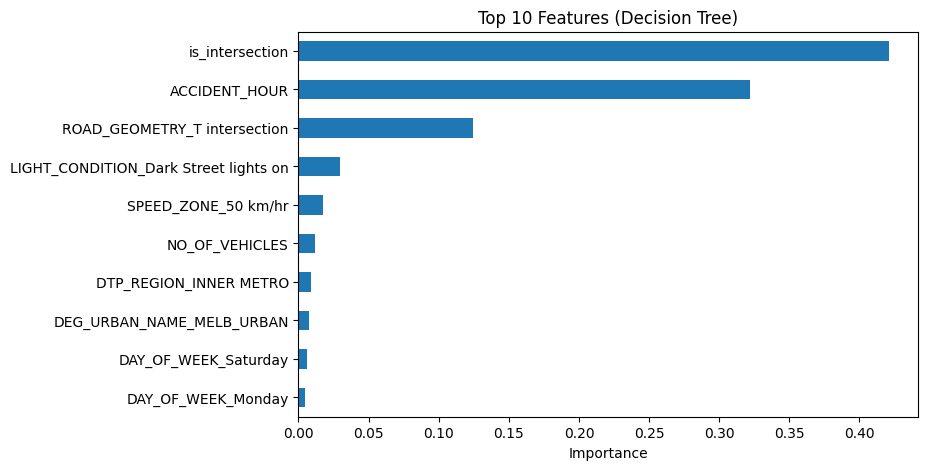

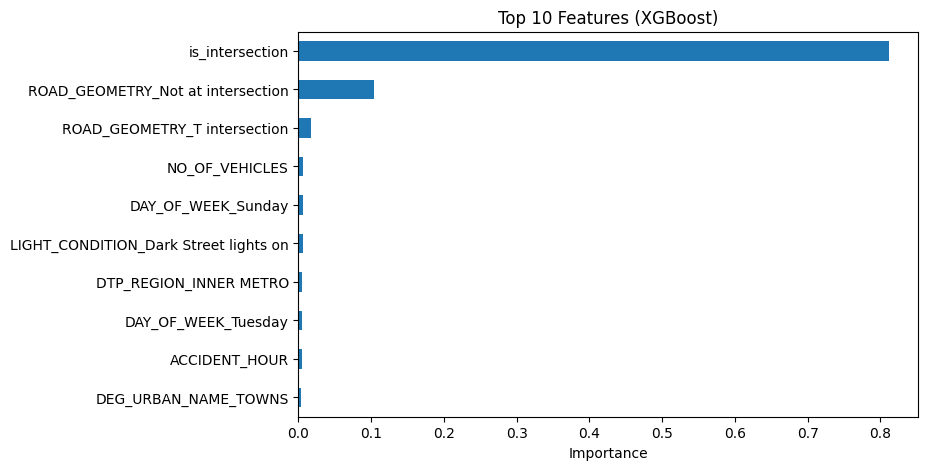

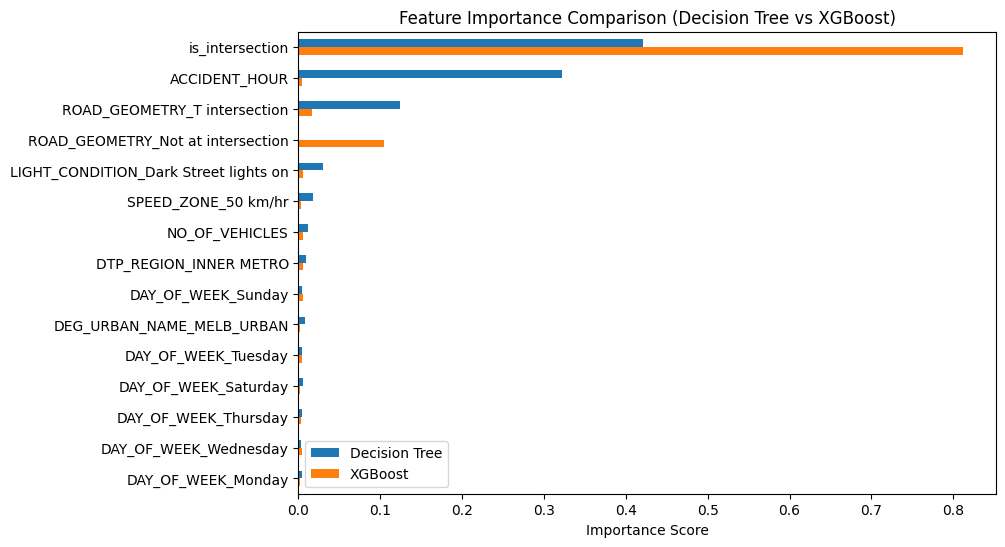

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


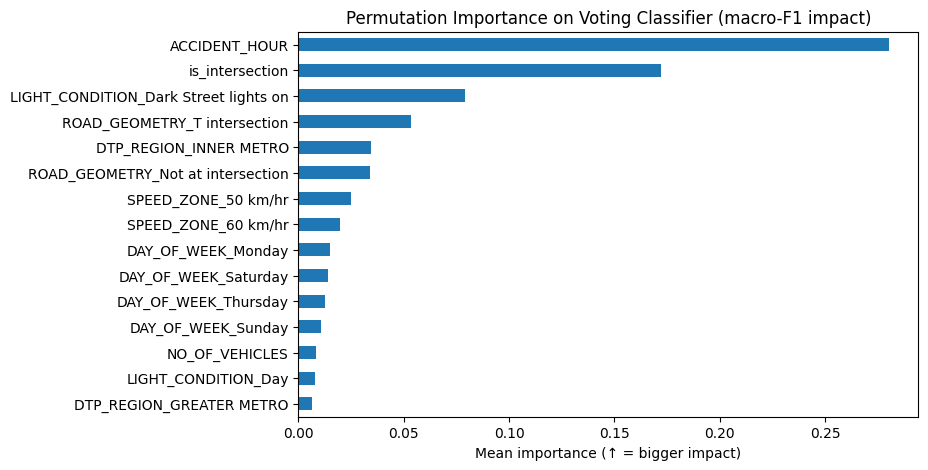

In [43]:
# === Feature importance (DROP-IN, no upstream changes) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Recover feature names safely (works even if X_train is a NumPy array)
def recover_feature_names():
    # Best case: X_train is a DataFrame
    if hasattr(globals().get("X_train", None), "columns"):
        return list(X_train.columns)

    # Next best: we still have X as a DataFrame from get_dummies(...)
    X_obj = globals().get("X", None)
    if hasattr(X_obj, "columns"):
        return list(X_obj.columns)

    # If features_df is around, rebuild the one-hot column names quickly
    features_df = globals().get("features_df", None)
    if hasattr(features_df, "columns"):
        try:
            X_tmp = pd.get_dummies(features_df.drop(columns=["risk_category"]), drop_first=True)
            return list(X_tmp.columns)
        except Exception:
            pass

    # Fallback: generic names
    n_cols = globals()["X_train"].shape[1]  # must exist
    return [f"feature_{i}" for i in range(n_cols)]

feat_names = recover_feature_names()

# 1) Build Series for DT & XGB (handle cases where attribute may not exist)
fi_dt = pd.Series(
    getattr(globals().get("best_dt", None), "feature_importances_", np.zeros(len(feat_names))),
    index=feat_names,
    name="Decision Tree"
)

fi_xgb = pd.Series(
    getattr(globals().get("best_xgb", None), "feature_importances_", np.zeros(len(feat_names))),
    index=feat_names,
    name="XGBoost"
)

# 2) Combine + rank
fi_all = pd.concat([fi_dt, fi_xgb], axis=1).fillna(0)
fi_all["Mean"] = fi_all[["Decision Tree", "XGBoost"]].mean(axis=1)
top15 = fi_all.sort_values("Mean", ascending=False).head(15)

# 3) Plots — DT top10
fi_dt.sort_values(ascending=False).head(10).plot(kind="barh", figsize=(8,5))
plt.title("Top 10 Features (Decision Tree)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

# XGB top10
fi_xgb.sort_values(ascending=False).head(10).plot(kind="barh", figsize=(8,5))
plt.title("Top 10 Features (XGBoost)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

# Comparison (DT vs XGB) on consensus top features
top15[["Decision Tree","XGBoost"]].plot(kind="barh", figsize=(9,6))
plt.title("Feature Importance Comparison (Decision Tree vs XGBoost)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()

# 4) (Optional) Permutation importance on final VotingClassifier (model-agnostic)
try:
    from sklearn.inspection import permutation_importance
    X_test_df = pd.DataFrame(X_test, columns=feat_names) if not hasattr(X_test, "columns") else X_test
    perm = permutation_importance(
        voter, X_test_df, y_test,
        scoring="f1_macro", n_repeats=10, random_state=42, n_jobs=-1
    )
    pi = pd.Series(perm.importances_mean, index=feat_names).sort_values(ascending=False).head(15)
    pi.plot(kind="barh", figsize=(8,5))
    plt.title("Permutation Importance on Voting Classifier (macro-F1 impact)")
    plt.xlabel("Mean importance (↑ = bigger impact)")
    plt.gca().invert_yaxis()
    plt.show()
except Exception as e:
    print("Permutation importance skipped:", e)


## Save model for deployment use
The model has been saved and is ready to be integrated into future systems

In [44]:
import joblib

# Save the trained VotingClassifier after fitting
joblib.dump(voter, "pedestrian_risk_voting_model.pkl")
print("Model saved as pedestrian_risk_voting_model.pkl")


Model saved as pedestrian_risk_voting_model.pkl


## Results and Implications

The Voting Classifier achieved strong predictive performance, with a Macro-F1 score of 0.8628 on the test set and 0.98 ± 0.0025 under cross-validation. Despite class imbalance, the model maintained good recall for the high-risk class, supported by the use of SMOTE oversampling.

Feature importance analysis provided deeper insight into what drives pedestrian crash risk. Across all models, intersections and time of day (ACCIDENT_HOUR) emerged as the most critical predictors. Decision Tree distributed importance more broadly, highlighting T-intersections, lighting conditions, and speed zones as meaningful secondary factors. XGBoost, in contrast, assigned overwhelming weight to intersections, showing that a single strong factor can dominate prediction. The Voting Classifier balanced these perspectives: permutation importance confirmed that intersections and accident hour remain dominant, but also gave weight to lighting (dark with street lights on), road geometry, speed zones (50–60 km/hr), and contextual factors such as inner metropolitan regions and number of vehicles involved in crashes. Even day-of-week patterns contributed smaller but consistent signals, suggesting differences between weekday commuting and weekend activity.

These findings are both statistically robust and practically significant. They show that pedestrian crash risk is not random but concentrated at predictable times and places — commuting peaks, intersections, poorly lit corridors, dense metro regions, and mid-speed urban roads. For urban planning, this translates into actionable recommendations: prioritise intersection redesigns, improve street lighting in high-exposure zones, introduce traffic calming or reduced speed limits in pedestrian-heavy corridors, and pay closer attention to inner metropolitan hotspots where traffic and pedestrian flows intersect most intensely. By linking predictors to interventions, the model provides a clear bridge between machine learning insights and planning decisions.

From a technical perspective, developing the Voting Classifier reinforced the value of ensemble methods. Decision Tree offered interpretability, XGBoost delivered accuracy, and their combination achieved both stability and reliability. Tools such as feature importance and permutation analysis were essential in ensuring interpretability, building trust in the model, and translating outputs into meaningful guidance for policymakers.

Beyond academic evaluation, the model supports a shift from reactive crash analysis to proactive prevention, helping to create safer and more walkable cities.

##  Limitations and Future Work

The model demonstrates strong performance, with high accuracy and balanced F1 scores, using only road environment features. While effective within this scope, there are natural opportunities to extend and strengthen its utility further.

**Feature Scope**

Current predictors focus on road layout, time, lighting, region, and vehicle counts. These provide valuable signals but capture only part of the picture.

Key factors such as pedestrian counts, vehicle volumes, weather conditions, and land use are missing. For example, the “inner metro” region variable was moderately important, but it is a broad proxy — integrating pedestrian and traffic flow data could sharpen its predictive power. Similarly, “number of vehicles” showed some influence, but more detailed exposure data (traffic density, pedestrian volume) would make the relationship clearer.

**Definition of Risk**

Risk was defined by crash frequency (1–2 = low, 3+ = high). This provides a simple and transparent baseline but does not account for severity.

Future work could refine this by weighting crashes by injury or fatality severity or by adjusting for exposure (e.g., crashes per pedestrian crossing volume). This would produce a more nuanced measure of risk and better align predictions with real-world safety outcomes.

**Generalisability**

The model was trained on Victorian crash data. It showed strong stability under cross-validation, but generalisability to other regions or years has not yet been tested.

Urban layouts, lighting standards, and pedestrian behaviour vary across jurisdictions. Testing on other Australian states or future years of Victorian data would confirm adaptability and identify potential model drift.

**Class Balance**

High-risk sites are naturally less common in the dataset. While SMOTE oversampling improved recall, the imbalance remains a challenge.

Future research could test cost-sensitive learning, ensemble resampling, or focal loss to further enhance the model’s ability to detect rare but critical high-risk sites.

**Looking Ahead**

Future development should focus on data enrichment, spatial-temporal modelling, and deployment pathways. Incorporating time-series data (e.g., seasonal or weekday vs weekend patterns) could capture dynamic exposure effects. Spatial clustering techniques could identify risk corridors rather than single points.

From a practical standpoint, the next step is to package the model into an interactive dashboard or GIS tool, where predictions can be visualised as heatmaps. This would allow policymakers to explore risk hotspots, compare scenarios (e.g., adding a crossing, reducing speed), and test interventions proactively.

With these extensions, the model could evolve from a strong analytical prototype into a decision-support system, helping transport agencies allocate resources efficiently, improve safety equitably across regions, and move from reactive crash analysis toward proactive prevention.

**Dashboard**

An interactive Streamlit dashboard for exploring temporal, spatial, and design-related drivers of pedestrian crash risk in Melbourne. It supports urban-planning decisions by surfacing when risk is high, where hotspots occur, and what design/speed factors correlate with higher risk.

Key outputs.

Time patterns: risk mix by hour; % high-risk by weekday × hour

Hotspots: clustered location view and top location cells

Road design & speed: % high by road geometry and speed zone

Vulnerable users: involvement vs. risk

Installation

In [45]:
pip install streamlit altair pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.5 MB/s eta 0:00:00


Create Dashboard

This next cell writes and runs a Streamlit app (dashboard_risk.py) that visualises pedestrian crash risk from features_df.csv. It:

1.Loads the dataset and maps risk_category -> readable labels (Low/
Medium/High).

2.Cleans ACCIDENT_HOUR to 0–23 and converts DAY_OF_WEEK into weekday names (handles numbers and text).

3.Adds interactive filters (risk, hour range, road geometry, speed zone).

Renders planner-focused tabs:

-Overview: KPIs, crashes by hour (grouped bars), and a location map.

-Patterns Over Time: 100% stacked area (risk mix by hour) and a weekday × hour heatmap of % High risk.

-Hotspots & Locations: Top rounded lat/lon cells ranked by crashes with % High.

-Road Design & Speed: % High by ROAD_GEOMETRY and by SPEED_ZONE.

-Vulnerable Users: Avg. vulnerable_total by risk and % of crashes with any vulnerable user.

In [46]:
%%writefile dashboard_risk.py
import pandas as pd
import numpy as np
import streamlit as st
import altair as alt
from pandas.api.types import is_integer_dtype, is_numeric_dtype

st.set_page_config(page_title="Pedestrian Crash Risk Dashboard", layout="wide")

# =========================
# Load data
# =========================
@st.cache_data(show_spinner=False)
def load_df(path="features_df.csv"):
    try:
        return pd.read_csv(path, encoding="latin1")
    except FileNotFoundError:
        st.error("Couldn't find 'features_df.csv' next to dashboard_risk.py.")
        st.stop()
    except Exception as e:
        st.error(f"Failed to read 'features_df.csv': {e}")
        st.stop()

df = load_df()
st.title("Pedestrian Crash Risk Dashboard")
st.caption(
    f"Loaded rows: {len(df):,}. Columns: "
    + ", ".join(map(str, df.columns))
)

# =========================
# Helpers
# =========================
def coerce_hour(series):
    s = pd.to_numeric(series, errors="coerce").round()
    s = s.clip(lower=0, upper=23)
    return s.astype("Int64")

def to_weekday(s):
    """Map DAY_OF_WEEK in almost any format to full weekday names."""
    ser = pd.Series(s)

    # 1) String labels like "Mon", "monday", "SUN"
    if ser.dtype == object:
        txt = ser.astype(str).str.strip().str.lower()
        key = txt.str[:3]
        map3 = {
            "mon": "Monday", "tue": "Tuesday", "wed": "Wednesday",
            "thu": "Thursday", "fri": "Friday", "sat": "Saturday", "sun": "Sunday"
        }
        wk = key.map(map3)
        if wk.notna().sum() >= max(1, int(0.6 * len(ser.dropna()))):
            return wk
        # else fall through to numeric

    # 2) Numeric-looking values
    num = pd.to_numeric(ser, errors="coerce")
    base_mon = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    base_sun = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

    # 0..6 (Mon=0)
    if num.dropna().between(0,6).all():
        return num.map({i: base_mon[i] for i in range(7)})

    # 1..7 (Mon=1) or (Sun=1)
    if num.dropna().between(1,7).all():
        mapped_mon1 = num.map({i+1: base_mon[i] for i in range(7)})
        mapped_sun1 = num.map({i+1: base_sun[i] for i in range(7)})
        return mapped_mon1.where(mapped_mon1.notna(), mapped_sun1)

    # 3) Datetime / epoch timestamps
    dt = pd.to_datetime(ser, errors="coerce", dayfirst=True, infer_datetime_format=True)
    if dt.notna().any():
        return dt.dt.day_name()

    # 4) Give up
    return pd.Series(pd.NA, index=ser.index)

def label_from_risk(vals):
    ser = pd.Series(vals)
    if is_numeric_dtype(ser):
        uniq = np.sort(ser.dropna().unique())
        if len(uniq) == 2 and set(uniq).issubset({0,1}):
            return ser.map({0:"Low", 1:"High"})
        if len(uniq) == 3 and set(uniq).issubset({0,1,2}):
            return ser.map({0:"Low", 1:"Medium", 2:"High"})
    return ser.astype(str)

def percent_high(group):
    if len(group) == 0: return 0.0
    return (group["risk_label"].eq("High").mean() * 100.0)

# =========================
# Expect these columns (from your list)
# =========================
expected = [
    "LATITUDE","LONGITUDE","ACCIDENT_HOUR","DAY_OF_WEEK","SPEED_ZONE",
    "LIGHT_CONDITION","ROAD_GEOMETRY","is_intersection","NO_OF_VEHICLES",
    "INJ_OR_FATAL","FATALITY","SERIOUSINJURY","vulnerable_total",
    "DEG_URBAN_NAME","DTP_REGION","risk_category"
]
missing = [c for c in expected if c not in df.columns]
if missing:
    st.error(f"Missing expected columns: {missing}")
    st.stop()

# =========================
# Prepare canonical fields
# =========================
df["risk_label"]    = label_from_risk(df["risk_category"])
df["ACCIDENT_HOUR"] = coerce_hour(df["ACCIDENT_HOUR"])
df = df.dropna(subset=["ACCIDENT_HOUR"])
df["ACCIDENT_HOUR"] = df["ACCIDENT_HOUR"].astype(int)
df["WEEKDAY"]       = to_weekday(df["DAY_OF_WEEK"])

# =========================
# Sidebar filters
# =========================
risk_options = sorted(df["risk_label"].dropna().unique().tolist())
risk_filter = st.sidebar.multiselect("Select Risk Category", options=risk_options, default=risk_options)
df = df[df["risk_label"].isin(risk_filter)]

# Hour slider
if len(df):
    hmin, hmax = int(df["ACCIDENT_HOUR"].min()), int(df["ACCIDENT_HOUR"].max())
    hr_range = st.sidebar.slider("Hour filter", 0, 23, (hmin, hmax))
    df = df[(df["ACCIDENT_HOUR"] >= hr_range[0]) & (df["ACCIDENT_HOUR"] <= hr_range[1])]

#  extra filters
geo_opts = sorted(df["ROAD_GEOMETRY"].dropna().unique().tolist())
sel_geos = st.sidebar.multiselect("Road geometry", geo_opts, default=geo_opts[:10] if len(geo_opts)>10 else geo_opts)
if sel_geos: df = df[df["ROAD_GEOMETRY"].isin(sel_geos)]

spd_opts = sorted(df["SPEED_ZONE"].dropna().unique().tolist())
sel_spds = st.sidebar.multiselect("Speed zone", spd_opts, default=spd_opts[:10] if len(spd_opts)>10 else spd_opts)
if sel_spds: df = df[df["SPEED_ZONE"].isin(sel_spds)]

# =========================
# Tabs
# =========================
tab_over, tab_time, tab_loc, tab_design, tab_vuln = st.tabs(
    ["Overview", "Patterns Over Time", "Hotspots & Locations", "Road Design & Speed", "Vulnerable Users"]
)

# =========================
# Tab: Overview
# =========================
with tab_over:
    c1, c2, c3, c4 = st.columns(4)
    total_crashes = len(df)
    pct_high = df["risk_label"].eq("High").mean()*100 if total_crashes else 0
    peak_hour = int(df["ACCIDENT_HOUR"].mode().iloc[0]) if len(df) else "—"
    if len(df):
        hotspot = (
            df.assign(lat_r=df["LATITUDE"].round(3), lon_r=df["LONGITUDE"].round(3))
              .groupby(["lat_r","lon_r"]).size().sort_values(ascending=False).head(1)
        )
        top_hotspot = (f"{hotspot.index[0][0]}, {hotspot.index[0][1]} "
                       f"({int(hotspot.iloc[0])})") if len(hotspot) else "—"
    else:
        top_hotspot = "—"

    c1.metric("Total crashes (filtered)", f"{total_crashes:,}")
    c2.metric("% High risk", f"{pct_high:.1f}%")
    c3.metric("Peak crash hour", f"{peak_hour}")
    c4.metric("Top hotspot (rounded)", top_hotspot)

    st.markdown("### Crashes by hour of day, split by risk category")
    work = df.dropna(subset=["ACCIDENT_HOUR", "risk_label"]).copy()
    hour_cat = (
        work.groupby(["ACCIDENT_HOUR","risk_label"]).size().reset_index(name="count")
    )
    all_hours = pd.Index(range(24), name="ACCIDENT_HOUR")
    all_cats  = pd.Index(sorted(work["risk_label"].unique()), name="risk_label")
    hour_cat = (
        hour_cat.set_index(["ACCIDENT_HOUR","risk_label"])
                .reindex(pd.MultiIndex.from_product([all_hours, all_cats]), fill_value=0)
                .reset_index()
    )
    chart_hours = (
        alt.Chart(hour_cat)
           .mark_bar()
           .encode(
               x=alt.X("ACCIDENT_HOUR:O", title="Hour of day (0–23)"),
               y=alt.Y("count:Q", title="Crashes"),
               color=alt.Color("risk_label:N", title="Risk"),
               tooltip=["ACCIDENT_HOUR","risk_label","count"]
           ).properties(height=320)
    )
    st.altair_chart(chart_hours, use_container_width=True)

    st.markdown("### Crash locations map")
    map_df = df[["LATITUDE","LONGITUDE"]].dropna().rename(columns={"LATITUDE":"lat","LONGITUDE":"lon"})
    st.map(map_df)

# =========================
# Tab: Patterns Over Time
# =========================
with tab_time:
    cols = st.columns(2)

    with cols[0]:
        st.markdown("#### Risk mix by hour (100%)")
        mix = (
            df.groupby(["ACCIDENT_HOUR","risk_label"])
              .size().reset_index(name="count")
        )
        tot = mix.groupby("ACCIDENT_HOUR")["count"].transform("sum")
        mix["pct"] = (mix["count"] / tot) * 100
        area = (
            alt.Chart(mix)
               .mark_area()
               .encode(
                   x=alt.X("ACCIDENT_HOUR:O", title="Hour"),
                   y=alt.Y("pct:Q", stack="normalize", title="Share of crashes"),
                   color=alt.Color("risk_label:N", title="Risk"),
                   tooltip=["ACCIDENT_HOUR","risk_label",alt.Tooltip("pct:Q",format=".1f")]
               )
        )
        st.altair_chart(area, use_container_width=True)

    with cols[1]:
        st.markdown("#### % High risk by weekday & hour")
        have_weekday = df["WEEKDAY"].notna().any()
        if have_weekday:
            tmp = (
                df.groupby(["WEEKDAY","ACCIDENT_HOUR"])
                  .apply(lambda g: (g["risk_label"].eq("High").mean()*100) if len(g) else 0)
                  .reset_index(name="pct_high")
            )
            week_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
            if set(tmp["WEEKDAY"].dropna().unique()).issubset(set(week_order)):
                tmp["WEEKDAY"] = pd.Categorical(tmp["WEEKDAY"], categories=week_order, ordered=True)
            heat = (
                alt.Chart(tmp)
                   .mark_rect()
                   .encode(
                       x=alt.X("ACCIDENT_HOUR:O", title="Hour"),
                       y=alt.Y("WEEKDAY:N", title="Weekday"),
                       color=alt.Color("pct_high:Q", title="% High", scale=alt.Scale(scheme="reds")),
                       tooltip=["WEEKDAY","ACCIDENT_HOUR",alt.Tooltip("pct_high:Q", format=".1f")]
                   ).properties(height=320)
            )
            st.altair_chart(heat, use_container_width=True)
        else:
            st.info("DAY_OF_WEEK could not be mapped to weekday names. "
                    "Ensure values are numbers (0–6 or 1–7) or strings like 'Mon', 'Tuesday', etc.")

# =========================
# Tab: Hotspots & Locations
# =========================
with tab_loc:
    st.markdown("#### Top location cells (rounded) by crashes and % High")
    g = (
        df.assign(lat_r=df["LATITUDE"].round(3), lon_r=df["LONGITUDE"].round(3))
          .groupby(["lat_r","lon_r"])
          .agg(
              crashes=("risk_label","size"),
              pct_high=("risk_label", lambda s: (s.eq("High").mean()*100) if len(s) else 0)
          )
          .reset_index()
          .sort_values(["crashes","pct_high"], ascending=[False, False])
          .head(15)
    )
    grid = (
        alt.Chart(g)
           .mark_bar()
           .encode(
               x=alt.X("crashes:Q", title="Crashes"),
               y=alt.Y("lat_r:N", sort="-x", title="Latitude (rounded)"),
               color=alt.Color("pct_high:Q", title="% High", scale=alt.Scale(scheme="reds")),
               tooltip=["lat_r","lon_r","crashes", alt.Tooltip("pct_high:Q",format=".1f")]
           ).properties(height=360)
    )
    st.altair_chart(grid, use_container_width=True)

# =========================
# Tab: Road Design & Speed
# =========================
with tab_design:
    cols = st.columns(2)

    with cols[0]:
        st.markdown("#### % High by road geometry")
        geo_stats = (
            df.groupby("ROAD_GEOMETRY")
              .apply(percent_high)
              .reset_index(name="pct_high")
              .sort_values("pct_high", ascending=False)
        )
        geo_chart = (
            alt.Chart(geo_stats)
               .mark_bar()
               .encode(
                   x=alt.X("pct_high:Q", title="% High"),
                   y=alt.Y("ROAD_GEOMETRY:N", sort="-x", title="Road geometry"),
                   tooltip=["ROAD_GEOMETRY", alt.Tooltip("pct_high:Q", format=".1f")]
               ).properties(height=360)
        )
        st.altair_chart(geo_chart, use_container_width=True)

    with cols[1]:
        st.markdown("#### % High by speed zone")
        spd_stats = (
            df.groupby("SPEED_ZONE")
              .apply(percent_high)
              .reset_index(name="pct_high")
              .sort_values("pct_high", ascending=False)
        )
        spd_chart = (
            alt.Chart(spd_stats)
               .mark_bar()
               .encode(
                   x=alt.X("pct_high:Q", title="% High"),
                   y=alt.Y("SPEED_ZONE:N", sort="-x", title="Speed zone"),
                   tooltip=["SPEED_ZONE", alt.Tooltip("pct_high:Q", format=".1f")]
               ).properties(height=360)
        )
        st.altair_chart(spd_chart, use_container_width=True)

# =========================
# Tab: Vulnerable Users
# =========================
with tab_vuln:
    st.markdown("#### Vulnerable users vs risk")
    agg = (
        df.groupby("risk_label")["vulnerable_total"]
          .agg(["count","mean"])
          .reset_index()
          .rename(columns={"mean":"avg_vulnerable"})
    )
    c = (
        alt.Chart(agg)
           .mark_bar()
           .encode(
               x=alt.X("risk_label:N", title="Risk"),
               y=alt.Y("avg_vulnerable:Q", title="Avg. vulnerable count"),
               tooltip=["risk_label","count", alt.Tooltip("avg_vulnerable:Q", format=".2f")],
               color="risk_label:N"
           ).properties(height=320)
    )
    st.altair_chart(c, use_container_width=True)

    share = (
        df.assign(has_vuln=(pd.to_numeric(df["vulnerable_total"], errors="coerce").fillna(0) > 0).astype(int))
          .groupby("risk_label")["has_vuln"].mean().mul(100)
          .rename("pct_with_vulnerable").reset_index()
    )
    c2 = (
        alt.Chart(share)
           .mark_bar()
           .encode(
               x=alt.X("risk_label:N", title="Risk"),
               y=alt.Y("pct_with_vulnerable:Q", title="% crashes with vulnerable person"),
               tooltip=["risk_label", alt.Tooltip("pct_with_vulnerable:Q", format=".1f")],
               color="risk_label:N"
           ).properties(height=320)
    )
    st.altair_chart(c2, use_container_width=True)

Writing dashboard_risk.py


This cell installs the required Python packages (streamlit, altair, pyarrow) and then launches the Streamlit app defined in dashboard_risk.py.
The app runs on port 8501 in headless mode, and its logs are written to streamlit.log.


In [47]:
!pip install -q streamlit altair pyarrow
!streamlit run dashboard_risk.py --server.port 8501 --server.headless true &> streamlit.log &


**Create a Public Tunnel with Cloudflare**

This cell downloads the Cloudflare tunnel binary (cloudflared), makes it executable, and then starts a tunnel to the local Streamlit app running on port 8501.

When the tunnel launches, it will print a public URL (e.g., https://xxxxx.trycloudflare.com).
Open that URL in your browser to access.

In [48]:
!curl -L -o cloudflared https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared
!./cloudflared tunnel --url http://localhost:8501 --no-autoupdate


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 39.2M  100 39.2M    0     0  26.7M      0  0:00:01  0:00:01 --:--:-- 26.7M
2025-09-21T05:57:12Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
202

# **Deployment Report**

**1)	Deployment Options**

• Streamlit Cloud: Host an interactive Python app (filters + map + downloads) directly from a GitHub repo; auto-redeploy on push.

• GitHub Pages (static): Folium/Leaflet HTML + CSV/GeoJSON; zero servers (good fallback for static publishing).

• Google Cloud Run (serverless API/app): Containerised FastAPI for /predict and batch scoring; scales to zero, HTTPS built-in.

• AWS Lambda + API Gateway (serverless API): On-demand scoring with auth and throttling.


**2)	Streamlit Selection**

• Planner-friendly interactivity: live filters, file upload, downloads, and a map without managing servers.

• Simple ops: connect repo -> deploy. Each push redeploys. Built-in caching for data/artifacts.

• Fits our workflow: we keep GitHub for code reviews; Streamlit reads our CSV/GeoJSON and loads the joblib model for on the go scoring.

• Shareable & fast: public URL for demos. Private repos supported via Streamlit Secrets if needed.


**3)	Model Card (v1.0)**

• Model: Crash-Risk Location Classifier (VotingClassifier)

• Owners: Pedestrian Traffic Analysis sub team

• Intended Use: Prioritise locations for planner review, not for real-time safety or enforcement.

• Data: Victorian Road Crash Data (filtered). Aggregated by location. Engineered temporal, road, lighting, geometry, urban/region features. One-hot encoding.

• Target: y - Low (1) – 1-2 crash High (2) – 3 or more crashes

• Training: Stratified split, repeated stratified CV, class weights/SMOTE applied inside CV only.

• Primary Metric: Macro-F1 (test) = 0.8628.

• Artefact: artifacts/risk_model.joblib (full sklearn Pipeline).

• Version: v1.0.0. Update monthly or when data refreshes.


**4)	Version Control & App Summary**

• Repo layout:/app.py (Streamlit entry), /requirements.txt, /artifacts/ (joblib), /docs/ (risk_scores.csv, risk_points.geojson), /notebooks/, /scripts/.

• Process: feature branches -> PR review -> tagged releases (v1.x.x) with Changelog.

• App behaviour: loads CSV/GeoJSON for the map. Optionally loads joblib to score uploaded CSVs. Shows model version/date in the header.


**5)	Future Plan to Scale**

• API backend (optional): build a small FastAPI service for /predict and /score_batch, host on Google Cloud Run (or AWS Lambda + API Gateway).

• Keep Streamlit as UI: app calls the API for live scoring. Batch CSV/GeoJSON still refreshed nightly.

• Ops & monitoring: lightweight logs/metrics, simple drift check (class mix vs last month), API key for write endpoints.


**6)	Deployment Plan**

• Prepare repo with app, readme(requirements), joblib pipeline, and documents.

• Deploy on streamlit - share.streamlit.io - New app - Select repo, branch, and app.py as the entry file.

• Push to Github

• Streamlit will continue to read from the repo


**7)	Post Deployment Checklist**
•App loads and shows map.

• Model version/date visible in the app

